In [10]:
# Imports
import sys
import os

# Add the upstream directory to sys.path
upstream_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
if upstream_dir not in sys.path:
    sys.path.insert(0, upstream_dir)

# Now you can import the module
from opentrons_api import ot2_api
from microtissue_manipulator import core, utils, camera
import numpy as np 
import cv2
import time
import json
import keyboard
# from pynput import keyboard
import paths
import matplotlib.pyplot as plt
import requests
import datetime
import threading
import queue
import string
import pandas as pd
import multiprocessing as mp
from dataclasses import dataclass, fields, asdict, MISSING
from typing import get_type_hints, get_origin, get_args, Tuple, List, Dict, Any, Union
from ultralytics import YOLO
# from typeguard import typechecked
# from typeguard import install_import_hook
# install_import_hook('__main__')

In [11]:
cam_manager = camera.CameraManagerWindows()
print("Connected cameras:")
print(cam_manager.list_labels())

under_cam = camera.open_capture('underview_cam', cam_manager=cam_manager, resolution = (2000,1500), focus = 940)
over_cam = camera.open_capture('overview_cam', cam_manager=cam_manager)
frame_ops = camera.frameOperations(*over_cam.shape[0:-1])

calibration_profile = 'checkerboard'
frame_ops.load_camera_intrinsics(config_profile=calibration_profile, use_new_cam_mtx=True)


Connected cameras:
{'underview_cam': 'Arducam B0478 (USB3 48MP)', 'overview_cam': 'HD USB Camera'}


In [12]:
under_cam = camera.open_capture('underview_cam', cam_manager=cam_manager, resolution = (4000,3000), focus = 940)

In [ ]:
# Turn on camera
# calibration_profile = 'checkerboard'
# cap = core.Camera(1, config_profile=calibration_profile, use_new_cam_mtx=True)

Using camera without buffer ...
Camera initialized ...


# Video test

In [8]:
over_cam = camera.open_capture('overview_cam', cam_manager=cam_manager)


In [8]:
under_cam = camera.open_capture('underview_cam', cam_manager=cam_manager, resolution = (2000,1500), focus = 890)

In [33]:
cv2.namedWindow("video", cv2.WINDOW_NORMAL)
cv2.resizeWindow("video", 1348, 1011)

# manual_movement = utils.ManualRobotMovement(openapi)
capture = over_cam
if not capture.is_opened():
    print("Error: Could not open video stream.")
else:
    print("Streaming video. Press 'q' to quit.")
    while True:
        ret, frame = capture.read()
        # frame = frame_ops.undistort_frame(frame)

        cv2.imshow("video", frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

# capture.release()
# keyboard.unhook_all()  # Unhook all keyboard listeners
cv2.destroyAllWindows()

Streaming video. Press 'q' to quit.


In [7]:
capture.release()

In [ ]:
model_path = os.path.join(paths.ML_MODELS_DIR,'tip_detector_v1.pt')
model = YOLO(model_path)
# Run inference
frame = frame[..., ::-1]  # Convert BGR to RGB as YOLO expects RGB input
results = model.predict(source=frame, save=False, imgsz=640,conf=0.1)

In [30]:
cap = cv2.VideoCapture(0)  # 0 is the default camera
if not cap.isOpened():
    print("Error: Could not open video capture.")
else:
    print("Video capture opened successfully.")
    cap.set(cv2.CAP_PROP_FRAME_WIDTH, 8000)
    cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 6000)
    cap.set(cv2.CAP_PROP_FOURCC, cv2.VideoWriter_fourcc(*'YUY2'))

cv2.namedWindow("video", cv2.WINDOW_NORMAL)
cv2.resizeWindow("video", 1348, 1011)

def set_focus(val):
    cap.set(cv2.CAP_PROP_FOCUS, val)
set_focus(900)


circle_center = (0, 0)

def draw_circle(event, x, y, flags, param):
    global circle_center
    if event == cv2.EVENT_LBUTTONDOWN:
        circle_center = (x, y)
        print(f"Circle center set to: {circle_center}")

cv2.setMouseCallback('video', draw_circle)
manual_movement = utils.ManualRobotMovement(openapi)
while(True):
    # Capture frame-by-frame
    ret, frame = cap.read()
    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    if circle_center != (0, 0):
        cv2.circle(frame, circle_center, 475, (0, 255, 0), 2)
    cv2.imshow('video', frame)
    k = cv2.waitKey(1) & 0xFF

    if k == ord('s'):
        print("frame saved")
        timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
        # filename = f'../outputs/images/underneath_dataset/saved_frame_{timestamp}.png'
        filename = f'../outputs/images/underneath_cuboids/saved_frame_{timestamp}.png'
        cv2.imwrite(filename, frame)

    if k == ord('q'):
        break

# When everything done, release the capture
cap.release()
keyboard.unhook_all()
cv2.destroyAllWindows()

Video capture opened successfully.
frame saved


In [4]:
window = cap.get_window()

robot_coords = []
camera_coords = []

while True:
    frame = cap.get_frame(undist=True)
    cv2.imshow(cap.window_name, frame)

    key_pressed = cv2.waitKey(1)

    if key_pressed == ord('q'):
        break

    elif key_pressed == ord('s'):
        timestamp = datetime.datetime.now().strftime('%Y_%m_%d_%H-%M-%S')
        filename = f"frame_{timestamp}.png"
        cv2.imwrite(os.path.join(paths.BASE_DIR, 'outputs', 'images', 'segmentation_test', filename), frame)
        print(f"Frame saved as {filename}")
   
cv2.destroyAllWindows()

# Init

In [12]:
# Connect the robot to the computer and this notebook
openapi = ot2_api.OpentronsAPI()

In [13]:
openapi.add_slot_offsets([5,8], (0,0,65))

In [14]:
# Use the light control to see if the robot is connected as a sanity check
openapi.toggle_lights()

<Response [200]>

In [15]:
# Always do once after robot was just turned on
openapi.home_robot()

Request status:
<Response [200]>
{
  "message": "Homing robot."
}


<Response [200]>

In [7]:
# Use to restore labware and general run information after the notebook crashes
r = openapi.get_run_info()

Total number of runs: 4
Current run ID: 29d4ae77-9e6f-45be-997f-1e4ab0bdad80
Current run status: idle


In [16]:
# Do after first launch
openapi.create_run()

Request status:
<Response [201]>
{
  "data": {
    "id": "25636676-6714-4b6f-89fe-3557d8674e59",
    "ok": true,
    "createdAt": "2025-05-23T06:22:17.570722Z",
    "status": "idle",
    "current": true,
    "actions": [],
    "errors": [],
    "hasEverEnteredErrorRecovery": false,
    "pipettes": [],
    "modules": [],
    "labware": [],
    "liquids": [],
    "liquidClasses": [],
    "labwareOffsets": [],
    "runTimeParameters": [],
    "outputFileIds": []
  }
}


<Response [201]>

In [17]:
# Let the robot know that it has the P300 pipette
openapi.load_pipette()

Request status:
<Response [201]>
{
  "data": {
    "id": "28a05731-e95e-49b8-9b3c-7bafe0c208d8",
    "createdAt": "2025-05-23T06:22:18.222157Z",
    "commandType": "loadPipette",
    "key": "28a05731-e95e-49b8-9b3c-7bafe0c208d8",
    "status": "succeeded",
    "params": {
      "pipetteName": "p300_single_gen2",
      "mount": "left"
    },
    "result": {
      "pipetteId": "94277960-2ff0-4a1e-8fb6-bfe0d68a95e9"
    },
    "startedAt": "2025-05-23T06:22:18.225324Z",
    "completedAt": "2025-05-23T06:22:20.179647Z",
    "intent": "setup",
    "notes": []
  }
}


<Response [201]>

In [13]:
openapi.move_to_coordinates((300,50,150), min_z_height=1, verbose=False)

<Response [201]>

In [18]:
openapi.move_relative('z', 20)

<Response [201]>

In [78]:
openapi.drop_tip_in_place()

<Response [201]>

In [23]:
openapi.control_run("stop")

<Response [201]>

# Under cam auto calibration

In [8]:
under_cam = camera.open_capture('underview_cam', cam_manager=cam_manager, resolution = (2000,1500), focus = 940)

### Robot coordinate system gauge

In [76]:
def get_tip_coordinates(results):
    for r in results:
        for box in r.boxes:
            cls = int(box.cls[0])
            if model.names[cls] == 'tip':
                tip_coords = ((int(box.xyxy[0][0]) + int(box.xyxy[0][2])) // 2, 
                                (int(box.xyxy[0][1]) + int(box.xyxy[0][3])) // 2)
                return tip_coords

movements = [None,('x', 3), ('y', 3)]

capture = under_cam
if not capture.is_opened():
    print("Error: Could not open video stream.")
else:
    for movement in movements:
        if movement is not None:
            axis, distance = movement
            openapi.move_relative(axis, distance)
            time.sleep(1)
        time.sleep(0.5)
        ret, frame = capture.read()
        if not ret:
            print("Error: Could not read frame from video stream.")
        else:   
            frame = frame[..., ::-1]  # Convert BGR to RGB as YOLO expects RGB input
            results = model.predict(
                    source=frame,  # Now pointing to a directory instead of a single file
                    conf=0.25,         # Confidence threshold
                    save=False,         # Save the annotated images
                    save_txt=False,    # Save YOLO-format prediction labels (optional)
                    show=False,         # Show images in pop-up windows (if GUI available)
                    imgsz=2000,
                    verbose = False        # Ensure inference matches your training resolution
                )
            tip_coords = get_tip_coordinates(results)
            print(f"Tip coordinates: {tip_coords}")
        if movement is not None:
            openapi.move_relative(axis, -distance)
            time.sleep(1)


  

WARNING  imgsz=[2000] must be multiple of max stride 32, updating to [2016]
Tip coordinates: (1050, 780)
WARNING  imgsz=[2000] must be multiple of max stride 32, updating to [2016]
Tip coordinates: (1049, 842)
WARNING  imgsz=[2000] must be multiple of max stride 32, updating to [2016]
Tip coordinates: (1112, 781)


### Find distance to tip

In [9]:
manual_movement = utils.ManualRobotMovement(openapi)

In [112]:
openapi.move_relative('x', 2)

<Response [201]>

In [10]:
keyboard.unhook_all()  # Unhook all keyboard listeners

In [117]:
under_cam.release()

In [10]:
# under_cam = camera.open_capture('underview_cam', cam_manager=cam_manager, resolution = (2000,1500), focus = 920)

cv2.namedWindow("video", cv2.WINDOW_NORMAL)
cv2.resizeWindow("video", 1348, 1011)
model_path = os.path.join(paths.ML_MODELS_DIR,'tip_detector_v1.pt')
model = YOLO(model_path)

manual_movement = utils.ManualRobotMovement(openapi)
capture = over_cam
if not capture.is_opened():
    print("Error: Could not open video stream.")
else:
    print("Streaming video. Press 'q' to quit.")
    while True:
        # if not capture.is_opened() or not capture.frame_ready.value:
        #     print("frame not ready or capture not opened, skipping frame.")
        #     continue
        ret, frame = capture.read()
        frame = frame[..., ::-1]  # Convert BGR to RGB as YOLO expects RGB input
        results = model.predict(
                source=frame,  # Now pointing to a directory instead of a single file
                conf=0.25,         # Confidence threshold
                save=False,         # Save the annotated images
                save_txt=False,    # Save YOLO-format prediction labels (optional)
                show=False,         # Show images in pop-up windows (if GUI available)
                imgsz=2016,
                verbose = False               # Ensure inference matches your training resolution
            )

        image = frame.copy()
        image_center = (image.shape[1] // 2, image.shape[0] // 2)
        data = []
        for r in results:
            for box in r.boxes:
                cls = int(box.cls[0])
                conf = float(box.conf[0])
                x1, y1, x2, y2 = map(int, box.xyxy[0])
                center_x = (x1 + x2) // 2
                center_y = (y1 + y2) // 2
                data.append({'class': model.names[cls], 'confidence': conf, 'center_x': center_x, 'center_y': center_y})

        # Create a dataframe
        df = pd.DataFrame(data)

        # Calculate the distance of each "point" to the center of the frame
        # df['distance_to_center'] = ((df['center_x'] - image_center[0]) ** 2 + (df['center_y'] - image_center[1]) ** 2) ** 0.5

        # # Identify the closest "point" to the center of the frame
        # df['is_closest_to_center'] = (df['class'] == 'point') & (df['distance_to_center'] == df.loc[df['class'] == 'point', 'distance_to_center'].min()) & (df['distance_to_center'] < 100)

        # if df['is_closest_to_center'].any():
        #     distances_from_closest = np.sqrt(
        #         (df.loc[df['is_closest_to_center'] & (df['class'] == 'point'), 'center_x'].values[0] - df.loc[df['class'] == 'point', 'center_x'])**2 +
        #         (df.loc[df['is_closest_to_center'] & (df['class'] == 'point'), 'center_y'].values[0] - df.loc[df['class'] == 'point', 'center_y'])**2
        #     )
        #     distances_from_closest = distances_from_closest[distances_from_closest > 0]
        #     linear_distance_ratio = 20.25 / np.mean(distances_from_closest)
        #      # Calculate the distance from the center-most "point" class to the "tip" class
        #     center_point_coords = df.loc[df['is_closest_to_center'], ['center_x', 'center_y']].values[0]
        #     # tip_coords = df.loc[df['class'] == 'tip', ['center_x', 'center_y']].values[0]

        #     # x_dist_to_tip = center_point_coords[0] - tip_coords[0]
        #     # y_dist_to_tip = center_point_coords[1] - tip_coords[1]
        #     # print(x_dist_to_tip, y_dist_to_tip)

        #     # y_dist_to_tip_mm = x_dist_to_tip * linear_distance_ratio
        #     # x_dist_to_tip_mm = y_dist_to_tip * linear_distance_ratio
        #     # print(f"x_dist_to_tip_mm: {x_dist_to_tip_mm}, y_dist_to_tip_mm: {y_dist_to_tip_mm}")

        #     # Draw center point coordinates
        #     cv2.circle(image, tuple(center_point_coords), 3, (0, 255, 0), -1)  # Green circle
        #     cv2.putText(image, f"Center {tuple(center_point_coords)}", tuple(center_point_coords), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

        # Draw tip coordinates
        # cv2.circle(image, tuple(tip_coords), 3, (0, 0, 255), -1)  # Red circle
        # cv2.putText(image, f"Tip {tuple(tip_coords)}", tuple(tip_coords), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

        cv2.imshow("video", image)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
 
# capture.release()
keyboard.unhook_all()  # Unhook all keyboard listeners
cv2.destroyAllWindows()

Streaming video. Press 'q' to quit.


In [35]:
df

""


In [115]:
openapi.move_relative('x', x_dist_to_tip_mm)
openapi.move_relative('y', y_dist_to_tip_mm)

<Response [201]>

# Requests experiments

### Add labware offsets to a run

In [27]:
r[-1]

{'id': '91935726-9671-40fe-a4db-90043934356f',
 'ok': True,
 'createdAt': '2025-03-24T20:33:35.152525+00:00',
 'status': 'idle',
 'current': True,
 'actions': [],
 'errors': [],
 'hasEverEnteredErrorRecovery': False,
 'pipettes': [{'id': 'f76919bd-9a3a-43c5-95b8-69dad2b1f74c',
   'pipetteName': 'p300_single_gen2',
   'mount': 'left'}],
 'modules': [],
 'labware': [{'id': 'd16a1b77-4f76-4ac2-868d-c93a047071e1',
   'loadName': 'corning_384_wellplate_112ul_flat',
   'definitionUri': 'opentrons/corning_384_wellplate_112ul_flat/1',
   'location': {'slotName': '3'}}],
 'liquids': [],
 'labwareOffsets': [{'id': '0fdb816f-5961-4bcf-a70a-0d8d65f63ade',
   'createdAt': '2025-03-24T20:46:44.080863+00:00',
   'definitionUri': 'opentrons/corning_384_wellplate_112ul_flat/1',
   'location': {'slotName': '3'},
   'vector': {'x': 0.0, 'y': 0.0, 'z': 65.0}}],
 'runTimeParameters': [],
 'outputFileIds': []}

In [26]:
# payload = {
#   "data": {
#     "definitionUri": "opentrons/corning_384_wellplate_112ul_flat/1",
#     "locationSequence": [
#       {
#         "kind": "onAddressableArea",
#         "addressableAreaName": "3"
#       }
#     ],
#     "vector": {
#       "x": 0,
#       "y": 0,
#       "z": 65
#     }
#   }
# }

data = {
    "data": {
                "definitionUri": "opentrons/corning_24_wellplate_3.4ml_flat/1",
                "location": {
                    "slotName": "3",
                    },
                "vector": {
                    "x": 0,
                    "y": 0,
                    "z": 65
                    }
}
}
payload = json.dumps(data)

In [24]:
r = requests.post(url = openapi.BASE_URL+'/runs/'+openapi.run_id +'/labware_offsets', headers = openapi.HEADERS, data = payload)

In [25]:
json.loads(r.text)

{'data': {'id': '0fdb816f-5961-4bcf-a70a-0d8d65f63ade',
  'createdAt': '2025-03-24T20:46:44.080863+00:00',
  'definitionUri': 'opentrons/corning_384_wellplate_112ul_flat/1',
  'location': {'slotName': '3'},
  'vector': {'x': 0.0, 'y': 0.0, 'z': 65.0}}}

### Other

In [ ]:
# data = {
#     "data": {
#         "labwareOffsets": [
#             {
#                 "definitionUri": "opentrons/corning_384_wellplate_112ul_flat/1",
#                 "location": {
#                     "slotName": "6",
#                     },
#                 "vector": {
#                     "x": 0,
#                     "y": 0,
#                     "z": 65
#                     }
#             }
#     ]
#     }
# }

# data = {
#   "data": {
#     "definitionUri": "opentrons/corning_384_wellplate_112ul_flat/1",
#     "locationSequence": [
#       {
#         "kind": "onAddressableArea",
#         "addressableAreaName": "3"
#       },
#       {
#         "kind": "onAddressableArea",
#         "addressableAreaName": "6"
#       }
#     ],
#     "vector": {
#       "x": 0,
#       "y": 0,
#       "z": 65
#     }
#   }
# }
# payload = json.dumps(data)

In [161]:
json.dumps(data)

'{"data": {"labwareOffsets": [{"definitionUri": "opentrons/corning_384_wellplate_112ul_flat/3", "location": {"slotName": "6"}, "vector": {"x": 0, "y": 0, "z": 65}}]}}'

In [27]:
r = requests.post(url = openapi.BASE_URL+'/labwareOffsets', headers = openapi.HEADERS, data = payload)

In [29]:
r = requests.get(url = openapi.BASE_URL+'/labwareOffsets', headers = openapi.HEADERS)

In [163]:
r = openapi.post("runs", openapi.HEADERS, data = json.dumps(data))

In [30]:
json.loads(r.text)

{'data': [{'id': '1b9a5217-1aee-4d36-b571-93003c28fa48',
   'createdAt': '2025-03-24T21:10:50.453740Z',
   'definitionUri': 'opentrons/corning_384_wellplate_112ul_flat/1',
   'location': {'slotName': '3'},
   'vector': {'x': 0.0, 'y': 0.0, 'z': 65.0}},
  {'id': '4241d90a-70a5-4a7f-ba7b-d281c07aa150',
   'createdAt': '2025-03-24T21:22:04.784248Z',
   'definitionUri': 'opentrons/corning_96_wellplate_360ul_flat/1',
   'location': {'slotName': '3'},
   'vector': {'x': 0.0, 'y': 0.0, 'z': 65.0}},
  {'id': 'd55868af-ab1e-4604-8209-5eb1356064fe',
   'createdAt': '2025-03-24T21:22:43.376258Z',
   'definitionUri': 'opentrons/corning_24_wellplate_3.4ml_flat/1',
   'location': {'slotName': '3'},
   'vector': {'x': 0.0, 'y': 0.0, 'z': 65.0}}],
 'meta': {'cursor': 0, 'totalLength': 3}}

In [ ]:
command_dict = {
            "data": {
                "commandType": "verifyTipPresence",
                "params": {
                    "pipetteId": openapi.pipette_id,
                    "expectedState": "present",
                },
                "intent": "setup"
            }
        }

command_payload = json.dumps(command_dict)
r = openapi.post("commands", headers = openapi.HEADERS,
                params={"waitUntilComplete": True}, data = command_payload)

# Labware declaration

### Opentrons 300 ul

In [8]:
#Define a tip rack. This is the default tip rack for the robot.
TIP_RACK = "opentrons_96_tiprack_300ul"
#Load the tip rack. Slot = 1 by default.
r = openapi.load_labware(TIP_RACK, 11)

Labware ID:
8312f64f-2b67-4e5d-bf4c-f7bc5b2eb4ab



In [9]:
r = openapi.pick_up_tip(openapi.labware_dct['11'], "A1")

### VWR 200ul Wide bore

In [9]:
custom_labware_path = os.path.join(paths.BASE_DIR,'protocols','vwr_96_tiprack_200ul.json')
with open(custom_labware_path, 'r') as json_file:
    custom_labware = json.load(json_file)

command_dict = {
            "data": custom_labware
        }

command_payload = json.dumps(command_dict)

url = openapi.get_url('runs')+ f'/{openapi.run_id}/'+ 'labware_definitions'
r = requests.post(url = url, headers = openapi.HEADERS, params = {"waitUntilComplete": True}, data = command_payload)

In [10]:
#Define a tip rack. This is the default tip rack for the robot.
TIP_RACK = "wide_bore_200ul"
#Load the tip rack. Slot = 1 by default.
openapi.load_labware(TIP_RACK, 10, namespace='custom_beta',verbose=True)

Labware ID:
e2bbb12d-d3f3-4e43-b99c-ba8b771ee6c1



<Response [201]>

In [11]:
r = openapi.pick_up_tip(openapi.labware_dct['10'], "A1")

In [8]:
openapi.drop_tip_in_place()

<Response [201]>

### VWR 200 ul XL

In [18]:
custom_labware_path = os.path.join(paths.BASE_DIR,'protocols','vwr_96_tiprack_200ul_xl.json')
with open(custom_labware_path, 'r') as json_file:
    custom_labware = json.load(json_file)

command_dict = {
            "data": custom_labware
        }

command_payload = json.dumps(command_dict)

url = openapi.get_url('runs')+ f'/{openapi.run_id}/'+ 'labware_definitions'
r = requests.post(url = url, headers = openapi.HEADERS, params = {"waitUntilComplete": True}, data = command_payload)

In [19]:
#Define a tip rack. This is the default tip rack for the robot.
TIP_RACK = "vwr_96_tiprack_200ul_xl"
#Load the tip rack. Slot = 1 by default.
openapi.load_labware(TIP_RACK, 10, namespace='custom_beta',verbose=True)

Labware ID:
3e2e9743-c42a-458f-aaba-b44922348525



<Response [201]>

In [20]:
r = openapi.pick_up_tip(openapi.labware_dct['10'], "A1")

### Reservoir and well plates

In [22]:
RESERVOIR = "corning_6_wellplate_16.8ml_flat"
r = openapi.load_labware(RESERVOIR, 4, namespace='opentrons',verbose=True)

Labware ID:
e378872e-6669-487b-8738-1b5cc257633f



In [21]:
WELL_PLATE = "corning_96_wellplate_360ul_flat"
# WELL_PLATE = "corning_24_wellplate_3.4ml_flat"
# WELL_PLATE = "corning_384_wellplate_112ul_flat"
r = openapi.load_labware(WELL_PLATE, 5, namespace='opentrons',verbose=True)

Offset (0, 0, 65) added to run for corning_96_wellplate_360ul_flat in slot 5.
Labware URI:
opentrons/corning_96_wellplate_360ul_flat/1

Check offset before using ...
Labware ID:
5bab6b40-cde0-4dc7-9ac0-24c26b6165da



In [25]:
openapi.drop_tip_in_place()

<Response [201]>

In [25]:
openapi.drop_tip(openapi.labware_dct['10'], "B11")

Exception: {"errors":[{"id":"InvalidRequest","title":"Invalid Request","detail":"none is not an allowed value","source":{"pointer":"/data/DropTipCreate/params/labwareId"},"errorCode":"4000"}]}

In [36]:
openapi.aspirate(openapi.labware_dct['3'], "A1", well_location='center', volume = 70, flow_rate = 200)

<Response [201]>

In [19]:
openapi.move_to_well(openapi.labware_dct['6'], "A1", well_location='top', offset=(0,0,0))

<Response [201]>

In [23]:
openapi.move_labware(openapi.labware_dct['8'], new_location='offDeck')

<Response [201]>

In [15]:
openapi.move_relative('z', 20)

<Response [201]>

In [26]:
flow_rate = 200
volume = 100

openapi.aspirate_in_place(flow_rate = flow_rate, volume = volume, verbose=True)

Request status:
<Response [201]>
{
  "data": {
    "id": "b4858090-6029-450e-9f62-9d6252bfb259",
    "createdAt": "2025-03-24T14:10:18.148471+00:00",
    "commandType": "aspirateInPlace",
    "key": "b4858090-6029-450e-9f62-9d6252bfb259",
    "status": "failed",
    "params": {
      "flowRate": 200.0,
      "volume": 100.0,
      "pipetteId": "3060ce35-522f-497b-adec-cca5e0da92a6"
    },
    "error": {
      "id": "6052d7ea-4f5e-41f7-8d95-f9eccadfb92f",
      "createdAt": "2025-03-24T14:10:18.157460+00:00",
      "isDefined": false,
      "errorType": "TipNotAttachedError",
      "errorCode": "3005",
      "detail": "Pipette should have a tip attached, but does not.",
      "errorInfo": {},
      "wrappedErrors": []
    },
    "startedAt": "2025-03-24T14:10:18.150583+00:00",
    "completedAt": "2025-03-24T14:10:18.157460+00:00",
    "intent": "setup",
    "notes": [
      {
        "noteKind": "debugErrorRecovery",
        "shortMessage": "Handling this command failure with FAIL_RUN."

<Response [201]>

In [12]:
flow_rate = 200
volume = 100
openapi.dispense_in_place(flow_rate = flow_rate, volume = volume)

<Response [201]>

# Filling a well plate

### Rinse pipette

In [ ]:
rinse_location = 3
well_to_wash = "A1"
well_to_rinse = "B1"
for i in range(3):
    openapi.aspirate(openapi.labware_dct[str(rinse_location)], well_to_wash, well_location='bottom', offset=(0,0,1), volume = 100, flow_rate = 200)
    openapi.dispense(openapi.labware_dct[str(rinse_location)], well_to_wash, well_location='bottom', offset=(0,0,1), volume = 100, flow_rate = 200)

for i in range(3):
    openapi.aspirate(openapi.labware_dct[str(rinse_location)], well_to_rinse, well_location='bottom', offset=(0,0,1), volume = 100, flow_rate = 200)
    openapi.dispense(openapi.labware_dct[str(rinse_location)], well_to_rinse, well_location='bottom', offset=(0,0,1), volume = 100, flow_rate = 200)

openapi.move_to_well(openapi.labware_dct[str(rinse_location)], well_to_rinse, well_location='top', offset=(0,0,10))

### Other stuff

In [16]:
openapi.drop_tip_in_place()

<Response [201]>

In [11]:
openapi.move_to_well(openapi.labware_dct['5'], "A13", well_location='top', offset=(-0.1,0,0))

<Response [201]>

In [16]:
# Take solution off the well palte with cuboids

columns = list(range(1,7))
# rows = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P']
rows = ['B']
x_offset = -0.1
y_offset = 0
z_offset = 0
takeoff_volume = 100

row_idx = 0
column_idx = 0

while row_idx < len(rows):
    row = rows[row_idx]
    while column_idx < len(columns):
        column = columns[column_idx]
        r = openapi.aspirate(openapi.labware_dct['5'], f"{row}{column}", well_location = 'center', offset = (x_offset, y_offset, -2), volume = takeoff_volume//2, flow_rate = 20)
        # responce_dict = json.loads(r.text)['data']
        r = openapi.aspirate(openapi.labware_dct['5'], f"{row}{column}", well_location = 'bottom', offset = (x_offset, y_offset, z_offset), volume = takeoff_volume//2, flow_rate = 10)
        responce_dict = json.loads(r.text)['data']
        if responce_dict['status'] == 'failed':
            if responce_dict['error']['errorType'] == 'InvalidAspirateVolumeError':
                print('Dumping fluid')
                openapi.blow_out(openapi.labware_dct['4'], "A2", well_location='center', flow_rate = 200)
        else:
            column_idx += 1
    column_idx = 0
    row_idx += 1

openapi.blow_out(openapi.labware_dct['4'], "A2", well_location='center', flow_rate = 200)
openapi.move_relative('z', 20)


Dumping fluid
Dumping fluid


<Response [201]>

In [15]:
openapi.move_relative('z', 20)

<Response [201]>

In [44]:
openapi.drop_tip_in_place()

<Response [201]>

In [ ]:
openapi.blow_out(openapi.labware_dct['5'], "A1", well_location='top', flow_rate = 200)

<Response [201]>

In [41]:
r = openapi.dispense(openapi.labware_dct['3'], f"A1", well_location = 'center', volume = 70, flow_rate = 200)

In [24]:
openapi.move_relative('z', 20)

<Response [201]>

In [23]:
openapi.move_to_well(openapi.labware_dct['5'], "A1", well_location='top', offset=(0,0,0))

<Response [201]>

In [25]:
columns = list(range(1,13))
# rows = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P']
rows = ['A', 'B']
x_offset = 0
y_offset = 0

row_idx = 0
column_idx = 0

while row_idx < len(rows):
    row = rows[row_idx]
    while column_idx < len(columns):
        column = columns[column_idx]
        r = openapi.dispense(openapi.labware_dct['5'], f"{row}{column}", well_location = 'bottom', offset = (x_offset, y_offset, 0), volume = 100, flow_rate = 200)
        openapi.move_relative('z', 20)
        responce_dict = json.loads(r.text)['data']
        if responce_dict['status'] == 'failed':
            if responce_dict['error']['errorType'] == 'InvalidDispenseVolumeError':
                print('Refilling pipette')
                openapi.aspirate(openapi.labware_dct['4'], "A1", well_location ='bottom', volume = 200, flow_rate = 200)
        else:
            column_idx += 1
    column_idx = 0
    row_idx += 1

openapi.blow_out(openapi.labware_dct['4'], "A1", well_location='center', flow_rate = 200)
openapi.aspirate(openapi.labware_dct['4'], "A2", volume = 50, flow_rate = 200)
openapi.dispense(openapi.labware_dct['4'], "A2", volume = 50, flow_rate = 200)

Refilling pipette
Refilling pipette
Refilling pipette
Refilling pipette
Refilling pipette
Refilling pipette
Refilling pipette
Refilling pipette
Refilling pipette
Refilling pipette
Refilling pipette
Refilling pipette


<Response [201]>

In [27]:
openapi.blow_out(openapi.labware_dct['3'], "A1", well_location='center', flow_rate = 200)
openapi.aspirate(openapi.labware_dct['3'], "A2", volume = 50, flow_rate = 200)
openapi.dispense(openapi.labware_dct['3'], "A2", volume = 50, flow_rate = 200)

<Response [201]>

In [ ]:
json.loads(r.text)['data']['error']['errorType']

{'id': 'dec84017-3246-49d5-8548-ccfe85aa2350',
 'createdAt': '2024-11-02T03:44:26.715454+00:00',
 'isDefined': False,
 'errorType': 'InvalidDispenseVolumeError',
 'errorCode': '4000',
 'detail': 'Cannot dispense 50.0 µL when only 0.0 µL has been aspirated.',
 'errorInfo': {},
 'wrappedErrors': []}

# Robot <-> camera calibration

In [26]:
squaresX=7
squaresY=5 
squareLength=0.022
markerLength=0.011
aruco_dict = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_6X6_250)
params = cv2.aruco.DetectorParameters()
detector = cv2.aruco.ArucoDetector(aruco_dict, params)
board = cv2.aruco.CharucoBoard((squaresX, squaresY), squareLength, markerLength, aruco_dict)
calibration_data = utils.load_calibration_config(calibration_profile)
manual_movement = utils.ManualRobotMovement(openapi)

calib_origin = calibration_data['calib_origin']
openapi.move_to_coordinates(calib_origin, min_z_height=1, verbose=False)

cv2.namedWindow("video", cv2.WINDOW_NORMAL)
cv2.resizeWindow("video", 1348, 1011)

robot_coords = []
camera_coords = []

while True:
 # Capture frame-by-frame
    ret, frame = over_cam.read()
    frame = frame_ops.undistort_frame(frame)

    x, y, z = openapi.get_position(verbose=False)[0].values()
    (text_width, text_height), _ = cv2.getTextSize(f"Robot coords: ({x:.2f}, {y:.2f}, {z:.2f})", cv2.FONT_HERSHEY_SIMPLEX, 1, 2)
    cv2.rectangle(frame, (10, 0), (10 + text_width, text_height + 100), (0, 0, 0), -1)
    cv2.putText(frame, f"Robot coords: ({x:.2f}, {y:.2f}, {z:.2f})", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    cv2.putText(frame, f"Step size: {manual_movement.step} mm", (10, 70), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

    center_screen_x = frame.shape[1] // 2
    center_screen_y = frame.shape[0] // 2
    cv2.circle(frame, (center_screen_x, center_screen_y), 5, (0, 0, 255), -1)
    cv2.putText(frame, f"Center: ({center_screen_x}, {center_screen_y})", (center_screen_x + 10, center_screen_y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)

    # Calculate the center of each quarter of the screen
    quarter_centers = [
        (center_screen_x // 2, center_screen_y // 2),
        (3 * center_screen_x // 2, center_screen_y // 2),
        (center_screen_x // 2, 3 * center_screen_y // 2),
        (3 * center_screen_x // 2, 3 * center_screen_y // 2)
    ]

    # Draw circles at the center of each quarter
    for qx, qy in quarter_centers:
        cv2.circle(frame, (qx, qy), 5, (0, 255, 255), -1)
        cv2.putText(frame, f"({qx}, {qy})", (qx + 10, qy - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 255), 2)

    marker_corners, marker_ids, _ = detector.detectMarkers(frame)
    if marker_corners:
        for corner in marker_corners:
            corner = corner.reshape((4, 2))
            for point in corner:
                cv2.circle(frame, tuple(point.astype(int)), 5, (0, 255, 0), -1)

            center_x = int(np.mean(corner[:, 0]))
            center_y = int(np.mean(corner[:, 1]))
            cv2.circle(frame, (center_x, center_y), 5, (255, 0, 0), -1)
            cv2.putText(frame, f"({center_x}, {center_y})", (center_x + 10, center_y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

    # Calculate side lengths
    side_lengths = []
    if marker_corners:
        for corner in marker_corners[0]:
            for i in range(4):
                side_length = np.linalg.norm(corner[i] - corner[(i + 1) % 4])
                side_lengths.append(side_length)

    # Calculate the average side length
        average_side_length = np.mean(side_lengths)
        area = cv2.contourArea(marker_corners[0])
        one_d_ratio = 13.83 / average_side_length
        size_conversion_ratio = 13.83 ** 2 / area
        cv2.putText(frame, f"Area of marker: {area:.2f}", (10, 110), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    cv2.imshow("video", frame)

    key_pressed = cv2.waitKey(1)

    if key_pressed == ord('q'):
        keyboard.unhook_all()
        break
    elif key_pressed == ord('s'):
        x, y, z = openapi.get_position(verbose=False)[0].values()
        robot_coords.append((x, y))
        camera_coords.append((center_x, center_y))

# When everything done, release the capture
# cap.release_camera()
cv2.destroyAllWindows()

calibration_data = utils.load_calibration_config(calibration_profile)
calibration_data['size_conversion_ratio'] = size_conversion_ratio
calibration_data['one_d_ratio'] = one_d_ratio
utils.save_calibration_config(calibration_profile, calibration_data)

Saved position: {'x': 255.00000000000003, 'y': 145.25, 'z': 100.00000000000001}


In [27]:
spacing = 5  # Distance from the calib_point in mm

# Calculate the four coordinates
calibration_points = [
    (calib_origin[0] + spacing, calib_origin[1] + spacing),  # Right
    (calib_origin[0] + spacing, calib_origin[1] - spacing),  # Left
    (calib_origin[0] - spacing, calib_origin[1] - spacing),  # Up
    (calib_origin[0] - spacing, calib_origin[1] + spacing)   # Down
]

robot_coords = []
camera_coords = []


# window = cap.get_window()
cv2.namedWindow("video", cv2.WINDOW_NORMAL)
cv2.resizeWindow("video", 1348, 1011)

for calib_pt in calibration_points:
    openapi.move_to_coordinates((*calib_pt, 100), min_z_height=1, verbose=False)
    cv2.waitKey(1000)
    # frame = cap.get_frame(undist=True)
    ret, frame = over_cam.read()
    frame = frame_ops.undistort_frame(frame)
    
    x, y, z = openapi.get_position(verbose=False)[0].values()
    (text_width, text_height), _ = cv2.getTextSize(f"Robot coords: ({x:.2f}, {y:.2f}, {z:.2f})", cv2.FONT_HERSHEY_SIMPLEX, 1, 2)
    cv2.rectangle(frame, (10, 0), (10 + text_width, text_height + 70), (0, 0, 0), -1)
    cv2.putText(frame, f"Robot coords: ({x:.2f}, {y:.2f}, {z:.2f})", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    cv2.putText(frame, f"Step size: {manual_movement.step} mm", (10, 70), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

    center_screen_x = frame.shape[1] // 2
    center_screen_y = frame.shape[0] // 2
    cv2.circle(frame, (center_screen_x, center_screen_y), 5, (0, 0, 255), -1)
    cv2.putText(frame, f"Center: ({center_screen_x}, {center_screen_y})", (center_screen_x + 10, center_screen_y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)

    # Calculate the center of each quarter of the screen
    quarter_centers = [
        (center_screen_x // 2, center_screen_y // 2),
        (3 * center_screen_x // 2, center_screen_y // 2),
        (center_screen_x // 2, 3 * center_screen_y // 2),
        (3 * center_screen_x // 2, 3 * center_screen_y // 2)
    ]

    # Draw circles at the center of each quarter
    for qx, qy in quarter_centers:
        cv2.circle(frame, (qx, qy), 5, (0, 255, 255), -1)
        cv2.putText(frame, f"({qx}, {qy})", (qx + 10, qy - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 255), 2)

    marker_corners, marker_ids, _ = detector.detectMarkers(frame)
    if marker_corners:
        for corner in marker_corners:
            corner = corner.reshape((4, 2))
            for point in corner:
                cv2.circle(frame, tuple(point.astype(int)), 5, (0, 255, 0), -1)

            center_x = int(np.mean(corner[:, 0]))
            center_y = int(np.mean(corner[:, 1]))
            cv2.circle(frame, (center_x, center_y), 5, (255, 0, 0), -1)
            cv2.putText(frame, f"({center_x}, {center_y})", (center_x + 10, center_y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

    cv2.waitKey(1)
    cv2.imshow("video", frame)
    x, y, z = openapi.get_position(verbose=False)[0].values()
    robot_coords.append((x, y))
    camera_coords.append((center_x, center_y))

cv2.destroyAllWindows()

# Write transformation matrix

In [28]:
calibration_data = utils.load_calibration_config(calibration_profile)

camera_coords = utils.sort_coordinates(camera_coords)
robot_coords = utils.sort_coordinates(robot_coords, reverse_y=True)

robot_to_camera_coords = {tuple(robot_coord): tuple(camera_coord) for robot_coord, camera_coord in zip(robot_coords, camera_coords)}
tf_mtx = utils.compute_tf_mtx(robot_to_camera_coords)

calibration_data['tf_mtx'] = tf_mtx.tolist()

utils.save_calibration_config(calibration_profile, calibration_data)

# Pipette offset calibration

### Blob detector

In [ ]:
calibration_data = utils.load_calibration_config(calibration_profile)

tf_mtx = np.array(calibration_data['tf_mtx'])
calib_origin = np.array(calibration_data['calib_origin'])[:2]
offset = np.array(calibration_data['offset'])


window = cap.get_window()

def on_mouse_click(event, x, y, flags, param):
    global circle_center
    global circle_radius
    global filtered_contours
    global X_init, Y_init

    if event == cv2.EVENT_MBUTTONDOWN:
        circle_center = (x, y)

    if event == cv2.EVENT_MOUSEWHEEL:
        if flags > 0:
            circle_radius += 10
        else:
            circle_radius -= 10

    if event == cv2.EVENT_LBUTTONDBLCLK:
        for contour in filtered_contours:
            r=cv2.pointPolygonTest(contour, (x,y), False)
            if r>0:
                M = cv2.moments(contour)
                if M["m00"] != 0:
                    cX = int(M["m10"] / M["m00"])
                    cY = int(M["m01"] / M["m00"])
                    X_init, Y_init, _ = tf_mtx @ (cX, cY, 1)

                    x, y, _ = openapi.get_position(verbose=False)[0].values()
                    diff = np.array([x,y]) - np.array(calibration_data['calib_origin'])[:2]
                    X = X_init + diff[0] + offset[0]
                    Y = Y_init + diff[1] + offset[1]
                    
                    print(f"Robot coords: ({x}, {y})")
                    print(f"Clicked on: ({X}, {Y})")
                    openapi.move_to_coordinates((X, Y, 15), min_z_height=1, verbose=False)
                    # openapi.aspirate_in_place(flow_rate = 75, volume = 10)

                    
                else:
                    print("Contour center could not be found")

    if event == cv2.EVENT_RBUTTONDOWN:
        x, y, _ = openapi.get_position(verbose=False)[0].values()
        # openapi.move_to_coordinates((x, y, 100), min_z_height=1)
        openapi.move_to_coordinates((calib_origin[0],calib_origin[1],100), min_z_height=1, verbose=False)

        

cv2.setMouseCallback(cap.window_name, on_mouse_click)
circle_center = (int(1296.0), int(972.0))
circle_radius = 300
manual_movement = utils.ManualRobotMovement(openapi)

while True:
    frame = cap.get_frame(undist=True)
    x, y, z = openapi.get_position(verbose=False)[0].values()
    (text_width, text_height), _ = cv2.getTextSize(f"Robot coords: ({x:.2f}, {y:.2f}, {z:.2f})", cv2.FONT_HERSHEY_SIMPLEX, 1, 2)
    cv2.rectangle(frame, (10, 0), (10 + text_width, text_height + 70), (0, 0, 0), -1)
    cv2.putText(frame, f"Robot coords: ({x:.2f}, {y:.2f}, {z:.2f})", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    cv2.putText(frame, f"Step size: {manual_movement.step} mm", (10, 70), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)


    cv2.circle(frame, circle_center, circle_radius, (255, 0, 0), 2)
    # Create a mask with the same dimensions as the frame
    mask = np.zeros_like(frame, dtype=np.uint8)

    # Draw a filled circle on the mask
    cv2.circle(mask, circle_center, circle_radius, (255, 255, 255), -1)

    # Apply the mask to the frame
    masked_frame = cv2.bitwise_and(frame, mask)

    # Convert the masked frame to grayscale
    gray = cv2.cvtColor(masked_frame, cv2.COLOR_BGR2GRAY)
    # Apply thresholding to the grayscale image
    _, thresh = cv2.threshold(gray, 50, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    # _, thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)
    # Fill the area outside the circle with black pixels
    # Convert the mask to grayscale
    mask_inv = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    thresh = cv2.bitwise_and(thresh, mask_inv)


    # Find contours in the masked frame
    contours, hei = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Filter the contours to exclude the outermost
    # filtered_contours = [contour for contour, h in zip(contours, hei[0]) if h[3] == 1]
    # Filter the contours by size
    filtered_contours = [contour for contour in contours if 15 < cv2.contourArea(contour) < 1000]
    # Draw the contours on the frame
    cv2.drawContours(frame, filtered_contours, -1, (0, 255, 0), 2)




    cv2.imshow(cap.window_name, frame)
    key_pressed = cv2.waitKey(1)
    if key_pressed == ord('o'):
        x, y, _ = openapi.get_position(verbose=False)[0].values()

        calibration_data['offset'] = [x-X_init, y-Y_init]

        utils.save_calibration_config(calibration_profile, calibration_data)

    elif key_pressed == ord('d'):
        openapi.dispense_in_place(flow_rate = 75, volume = 10)

    elif key_pressed == ord('a'):
        openapi.aspirate_in_place(flow_rate = 75, volume = 10)


    elif key_pressed == ord('q'):
        keyboard.unhook_all()
        break

        
cv2.destroyAllWindows()

### Crosshair detector

In [47]:
# Load the template image
# path = os.path.join(paths.BASE_DIR, 'outputs', 'images', 'target_template.png')
path = os.path.join(paths.BASE_DIR, 'outputs', 'images', 'target_template_2.png')
template = cv2.imread(path, 0)  # Replace 'template.png' with your template image path
template_height, template_width = template.shape[:2]

calibration_data = utils.load_calibration_config(calibration_profile)

tf_mtx = np.array(calibration_data['tf_mtx'])
calib_origin = np.array(calibration_data['calib_origin'])[:2]
offset = np.array(calibration_data['offset'])

# Perform multi-object detection using template matching
# Start video stream
def on_mouse_click(event, x, y, flags, param):
    global X_init, Y_init, diff
    if event == cv2.EVENT_LBUTTONDBLCLK:
        for (rect_x, rect_y, rect_w, rect_h) in rectangles:
            if rect_x <= x <= rect_x + rect_w and rect_y <= y <= rect_y + rect_h:
                cX = rect_x + rect_w // 2
                cY = rect_y + rect_h // 2

                X_init, Y_init, _ = tf_mtx @ (cX, cY, 1)
                print('init:', X_init, Y_init)

                x, y, _ = openapi.get_position(verbose=False)[0].values()
                diff = np.array([x,y]) - np.array(calibration_data['calib_origin'])[:2]
                X = X_init + diff[0] + offset[0]
                Y = Y_init + diff[1] + offset[1]
                
                print(f"Robot coords: ({x}, {y})")
                print(f"Clicked on: ({X}, {Y})")
                # openapi.move_to_coordinates((X, Y, 66.1), min_z_height=1, verbose=False)
                openapi.move_to_coordinates((X, Y, 15), min_z_height=1, verbose=False)
                break

    if event == cv2.EVENT_RBUTTONDOWN:
        x, y, _ = openapi.get_position(verbose=False)[0].values()
        openapi.move_to_coordinates((calib_origin[0],calib_origin[1],100), min_z_height=1, verbose=False)
        # openapi.move_to_coordinates((255, 145.25,100), min_z_height=1, verbose=False)

# window = cap.get_window()
cv2.namedWindow("video", cv2.WINDOW_NORMAL)
cv2.resizeWindow("video", 1348, 1011)
cv2.setMouseCallback("video", on_mouse_click)
manual_movement = utils.ManualRobotMovement(openapi)


while True:
    # Capture frame-by-frame
    # frame = cap.get_frame(undist=True)
    ret, frame = over_cam.read()
    frame = frame_ops.undistort_frame(frame)
    x, y, z = openapi.get_position(verbose=False)[0].values()
    (text_width, text_height), _ = cv2.getTextSize(f"Robot coords: ({x:.2f}, {y:.2f}, {z:.2f})", cv2.FONT_HERSHEY_SIMPLEX, 1, 2)
    cv2.rectangle(frame, (10, 0), (10 + text_width, text_height + 70), (0, 0, 0), -1)
    cv2.putText(frame, f"Robot coords: ({x:.2f}, {y:.2f}, {z:.2f})", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    cv2.putText(frame, f"Step size: {manual_movement.step} mm", (10, 70), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    # Draw the center of the frame
    frame_center_x = frame.shape[1] // 2
    frame_center_y = frame.shape[0] // 2
    cv2.circle(frame, (frame_center_x, frame_center_y), 5, (0, 0, 255), -1)
    cv2.putText(frame, "Center", (frame_center_x + 10, frame_center_y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)

    assert ret, "Failed to capture frame from over_cam."
    image = frame.copy()
    image = image[..., ::-1]  # Convert BGR to RGB as YOLO expects RGB input
    results = model.predict(
            source=image,  # Now pointing to a directory instead of a single file
            conf=0.25,         # Confidence threshold
            save=False,         # Save the annotated images
            save_txt=False,    # Save YOLO-format prediction labels (optional)
            show=False,         # Show images in pop-up windows (if GUI available)
            imgsz=2016,
            verbose = False               # Ensure inference matches your training resolution
        )

    image_center = (image.shape[1] // 2, image.shape[0] // 2)
    data = []
    for r in results:
        for box in r.boxes:
            cls = int(box.cls[0])
            conf = float(box.conf[0])
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            center_x = (x1 + x2) // 2
            center_y = (y1 + y2) // 2
            data.append({'class': model.names[cls], 'confidence': conf, 'center_x': center_x, 'center_y': center_y})

    # Select the point closest to the center of the image
    if data:
        closest_obj = min(
            (obj for obj in data if obj['class'] == 'point'),
            key=lambda obj: (obj['center_x'] - image_center[0]) ** 2 + (obj['center_y'] - image_center[1]) ** 2,
            default=None
        )
        if closest_obj is not None:
            cv2.circle(frame, (closest_obj['center_x'], closest_obj['center_y']), 8, (0, 255, 255), 2)
            cv2.putText(frame, "Closest", (closest_obj['center_x'] + 10, closest_obj['center_y'] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 255), 2)
    # for obj in data:
    #     if obj['class'] == 'point':
    #         cv2.circle(frame, (obj['center_x'], obj['center_y']), 3, (0, 255, 255), 2)
    # Perform template matching
    # result = cv2.matchTemplate(gray_frame, template, cv2.TM_CCOEFF_NORMED)
    # min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)


    # # Eliminate overlapping matches
    # locations = np.where(result >= 0.7)  # Adjust the threshold as needed
    # rectangles = []
    # for pt in zip(*locations[::-1]):
    #     rectangles.append([pt[0], pt[1], template_width, template_height])

    # # Apply non-maximum suppression to remove overlapping rectangles
    # rectangles, _ = cv2.groupRectangles(rectangles, groupThreshold=1, eps=0.2)
    # for (x, y, w, h) in rectangles:
    #     cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)
    #     center_x = x + w // 2
    #     center_y = y + h // 2
    #     cv2.circle(frame, (center_x, center_y), 3, (255, 0, 0), -1)
    #     cv2.putText(frame, f"({center_x}, {center_y})", (center_x + 10, center_y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

    # Display the resulting frame
    cv2.imshow("video", frame)

    key_pressed = cv2.waitKey(1)
    # Break the loop on 'q' key press
    if key_pressed == ord('o'):
        x, y, _ = openapi.get_position(verbose=False)[0].values()

        x_prev = X_init + diff[0] + offset[0]
        y_prev = Y_init + diff[1] + offset[1]

        print([x-(X_init+diff[0]), y-(Y_init+diff[1])])
        # calibration_data['offset'] = [x-X_init, y-Y_init]
        utils.save_calibration_config(calibration_profile, calibration_data)

    elif key_pressed == ord('d'):
        openapi.dispense_in_place(flow_rate = 75, volume = 10)

    elif key_pressed == ord('a'):
        openapi.aspirate_in_place(flow_rate = 75, volume = 10)


    elif key_pressed == ord('q'):
        keyboard.unhook_all()
        break


# Release resources
cv2.destroyAllWindows()

### Automatic

In [30]:
openapi.toggle_lights()

<Response [200]>

In [48]:
path = os.path.join(paths.BASE_DIR, 'outputs', 'images', 'target_template_2.png')
template = cv2.imread(path, 0)  # Replace 'template.png' with your template image path
template_height, template_width = template.shape[:2]
calibration_data = utils.load_calibration_config(calibration_profile)
tf_mtx = np.array(calibration_data['tf_mtx'])
calib_origin = np.array(calibration_data['calib_origin'])[:2]
offset = np.array(calibration_data['offset'])
model_path = os.path.join(paths.ML_MODELS_DIR,'tip_detector_v1.pt')
model = YOLO(model_path)


#Settings
calib_module_coordinates = (255, 145.25, 100)  # Coordinates for the pipette offset calibration module
calib_module_height = 69.3  # Height for the pipette offset calibration module
detection_offset_x = 2
detection_offset_y = 2  # Offset to apply to the detected coordinates
#Move to pipette offset calibration module:
openapi.move_to_coordinates(calib_module_coordinates, min_z_height=calib_module_height-0.1, verbose=False)
time.sleep(1)

ret, frame = over_cam.read()
assert ret, "Failed to capture frame from over_cam."
frame = frame_ops.undistort_frame(frame)
image = frame.copy()
image = image[..., ::-1]  # Convert BGR to RGB as YOLO expects RGB input
results = model.predict(
        source=image,  # Now pointing to a directory instead of a single file
        conf=0.25,         # Confidence threshold
        save=False,         # Save the annotated images
        save_txt=False,    # Save YOLO-format prediction labels (optional)
        show=False,         # Show images in pop-up windows (if GUI available)
        imgsz=2016,
        verbose = False               # Ensure inference matches your training resolution
    )

image_center = (image.shape[1] // 2, image.shape[0] // 2)
data = []
for r in results:
    for box in r.boxes:
        cls = int(box.cls[0])
        conf = float(box.conf[0])
        x1, y1, x2, y2 = map(int, box.xyxy[0])
        center_x = (x1 + x2) // 2
        center_y = (y1 + y2) // 2
        data.append({'class': model.names[cls], 'confidence': conf, 'center_x': center_x, 'center_y': center_y})

# Select the point closest to the center of the image
if data:
    closest_obj = min(
        (obj for obj in data if obj['class'] == 'point'),
        key=lambda obj: (obj['center_x'] - image_center[0]) ** 2 + (obj['center_y'] - image_center[1]) ** 2,
        default=None
    )
    if closest_obj is not None:
        cv2.circle(frame, (closest_obj['center_x'], closest_obj['center_y']), 8, (0, 255, 255), 2)
        cv2.putText(frame, "Closest", (closest_obj['center_x'] + 10, closest_obj['center_y'] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 255), 2)
assert closest_obj is not None, "No 'point' class detected in the image."
crosshair_x, crosshair_y = closest_obj['center_x'], closest_obj['center_y']

#Move to the center of the detected template
X_init, Y_init, _ = tf_mtx @ (crosshair_x, crosshair_y, 1)
print('init:', X_init, Y_init)

x, y, _ = openapi.get_position(verbose=False)[0].values()
diff = np.array([x,y]) - np.array(calibration_data['calib_origin'])[:2]
X = X_init + diff[0] + offset[0]
Y = Y_init + diff[1] + offset[1]

print(f"Robot coords: ({x}, {y})")
print(f"Clicked on: ({X}, {Y})")
openapi.move_to_coordinates((X + detection_offset_x, Y + detection_offset_y, calib_module_height), min_z_height=calib_module_height-0.1, verbose=False)
time.sleep(1)

ret, frame = under_cam.read()
assert ret, "Failed to capture frame from under_cam."
frame = frame[..., ::-1]  # Convert BGR to RGB as YOLO expects RGB input
results = model.predict(
        source=frame,  # Now pointing to a directory instead of a single file
        conf=0.25,         # Confidence threshold
        save=False,         # Save the annotated images
        save_txt=False,    # Save YOLO-format prediction labels (optional)
        show=False,         # Show images in pop-up windows (if GUI available)
        imgsz=2016,
        verbose = False               # Ensure inference matches your training resolution
    )

image = frame.copy()
image_center = (image.shape[1] // 2, image.shape[0] // 2)
data = []
for r in results:
    for box in r.boxes:
        cls = int(box.cls[0])
        conf = float(box.conf[0])
        x1, y1, x2, y2 = map(int, box.xyxy[0])
        center_x = (x1 + x2) // 2
        center_y = (y1 + y2) // 2
        data.append({'class': model.names[cls], 'confidence': conf, 'center_x': center_x, 'center_y': center_y})

# Create a dataframe
df = pd.DataFrame(data)

# Calculate the distance of each "point" to the center of the frame
df['distance_to_center'] = ((df['center_x'] - image_center[0]) ** 2 + (df['center_y'] - image_center[1]) ** 2) ** 0.5

# Identify the closest "point" to the center of the frame
df['is_closest_to_center'] = (df['class'] == 'point') & (df['distance_to_center'] == df.loc[df['class'] == 'point', 'distance_to_center'].min()) & (df['distance_to_center'] < 100)

if df['is_closest_to_center'].any():
    assert 'tip' in df['class'].values and 'point' in df['class'].values, "Both 'tip' and 'point' classes must be present in the dataframe."
    distances_from_closest = np.sqrt(
        (df.loc[df['is_closest_to_center'] & (df['class'] == 'point'), 'center_x'].values[0] - df.loc[df['class'] == 'point', 'center_x'])**2 +
        (df.loc[df['is_closest_to_center'] & (df['class'] == 'point'), 'center_y'].values[0] - df.loc[df['class'] == 'point', 'center_y'])**2
    )
    distances_from_closest = distances_from_closest[distances_from_closest > 0]
    linear_distance_ratio = 20.25 / np.mean(distances_from_closest)
        # Calculate the distance from the center-most "point" class to the "tip" class
    center_point_coords = df.loc[df['is_closest_to_center'], ['center_x', 'center_y']].values[0]
    tip_coords = df.loc[df['class'] == 'tip', ['center_x', 'center_y']].values[0]

    x_dist_to_tip = center_point_coords[0] - tip_coords[0]
    y_dist_to_tip = center_point_coords[1] - tip_coords[1]
    print(x_dist_to_tip, y_dist_to_tip)

    y_dist_to_tip_mm = x_dist_to_tip * linear_distance_ratio
    x_dist_to_tip_mm = y_dist_to_tip * linear_distance_ratio
    print(f"x_dist_to_tip_mm: {x_dist_to_tip_mm}, y_dist_to_tip_mm: {y_dist_to_tip_mm}")

assert x_dist_to_tip_mm and y_dist_to_tip_mm, "Failed to calculate distances to tip."
actual_offset_x = x_dist_to_tip_mm + detection_offset_x
actual_offset_y = y_dist_to_tip_mm + detection_offset_y
assert abs(actual_offset_x) < 10 and abs(actual_offset_y) < 10, "Offsets are too large, please check the calibration."
openapi.move_relative('x', x_dist_to_tip_mm, verbose=False)
openapi.move_relative('y', y_dist_to_tip_mm, verbose=False)

print(f"Actual offset applied: ({actual_offset_x}, {actual_offset_y}) mm")
x, y, _ = openapi.get_position(verbose=False)[0].values()
calibration_data['offset'] = [x-(X_init+diff[0]), y-(Y_init+diff[1])]
utils.save_calibration_config(calibration_profile, calibration_data)

init: 153.59992707496355 143.3729649370178
Robot coords: (255.00000000000003, 145.25)
Clicked on: (300.11450212510897, 222.7958473513129)
-22 -66
x_dist_to_tip_mm: -3.2756074643606636, y_dist_to_tip_mm: -1.091869154786888
Actual offset applied: (-1.2756074643606636, 0.908130845213112) mm


In [29]:
frame

In [35]:
openapi.move_relative('z', 20)

<Response [201]>

In [79]:
distances_from_closest = np.sqrt(
    (df.loc[df['is_closest_to_center'] & (df['class'] == 'point'), 'center_x'].values[0] - df.loc[df['class'] == 'tip', 'center_x'])**2 +
    (df.loc[df['is_closest_to_center'] & (df['class'] == 'point'), 'center_y'].values[0] - df.loc[df['class'] == 'tip', 'center_y'])**2
)

distances_from_closest

0    91.241438
dtype: float64

In [65]:
under_cam.release()

In [52]:
distances_from_closest = np.sqrt(
    (df.loc[df['is_closest_to_center'] & (df['class'] == 'point'), 'center_x'].values[0] - df.loc[df['class'] == 'point', 'center_x'])**2 +
    (df.loc[df['is_closest_to_center'] & (df['class'] == 'point'), 'center_y'].values[0] - df.loc[df['class'] == 'point', 'center_y'])**2
)

In [54]:
(df.loc[df['is_closest_to_center'] & (df['class'] == 'point'), 'center_x'].values[0] - df.loc[df['class'] == 'point', 'center_x'])

1    0
Name: center_x, dtype: int64

In [45]:
actual_offset_x, actual_offset_y

(nan, nan)

In [47]:
x_dist_to_tip_mm, y_dist_to_tip_mm

(nan, nan)

In [94]:
df

,class,confidence,center_x,center_y,distance_to_center,is_closest_to_center
0,point,0.971968,997,324,426.010563,False
1,tip,0.932559,1060,790,72.111026,False
2,point,0.849678,1043,1186,438.115282,False
3,point,0.765553,591,771,409.538765,False
4,point,0.762117,1452,727,452.584799,False
5,point,0.688305,1020,749,20.024984,True


# Slice picking

In [15]:
openapi.move_relative('z', 20)

<Response [201]>

In [49]:
calibration_data = utils.load_calibration_config(calibration_profile)

tf_mtx = np.array(calibration_data['tf_mtx'])
calib_origin = np.array(calibration_data['calib_origin'])[:2]
offset = np.array(calibration_data['offset'])

def on_mouse_click(event, cX, cY, flags, param):
    global X_init, Y_init, X, Y, target_x, target_y
    if event == cv2.EVENT_LBUTTONDOWN:
        target_x, target_y = cX, cY
        # print("Clicked at pixel coordinate: ({}, {})".format(cX, cY))
        X_init, Y_init, _ = tf_mtx @ (cX, cY, 1)

        x, y, _ = openapi.get_position(verbose=False)[0].values()
        diff = np.array([x,y]) - np.array(calibration_data['calib_origin'])[:2]
        X = X_init + diff[0] + offset[0]
        Y = Y_init + diff[1] + offset[1]
        print(cX, cY)
        print(X_init, Y_init)
        print(f"Robot coords: ({x}, {y})")
        print(f"Clicked on: ({X}, {Y})")
        # openapi.move_to_coordinates((X, Y, 80), min_z_height=1)

    if event == cv2.EVENT_RBUTTONDOWN:
        x, y, _ = openapi.get_position(verbose=False)[0].values()
        openapi.move_to_coordinates((300, 220, 100), min_z_height=1, verbose=False)

    # Use scrollwheel to change well name
    if event == cv2.EVENT_MOUSEWHEEL:
        # List of well names in 96-well plate (A1-H12)
        if not hasattr(on_mouse_click, "well_index"):
            on_mouse_click.well_index = 0
        if not hasattr(on_mouse_click, "well_names"):
            rows = "ABCDEFGH"
            cols = range(1, 13)
            on_mouse_click.well_names = [f"{row}{col}" for row in rows for col in cols]
        num_wells = len(on_mouse_click.well_names)
        # event flags: positive for scroll up, negative for scroll down
        if flags > 0:
            on_mouse_click.well_index = (on_mouse_click.well_index + 1) % num_wells
        else:
            on_mouse_click.well_index = (on_mouse_click.well_index - 1) % num_wells
        current_well = on_mouse_click.well_names[on_mouse_click.well_index]
        # print(f"Selected well: {current_well}")


# Create an instance of the ManualRobotMovement class
manual_movement = utils.ManualRobotMovement(openapi)

# window = cap.get_window()
cv2.namedWindow("video", cv2.WINDOW_NORMAL)
# cv2.resizeWindow("video", 1348, 1011)
cv2.resizeWindow("video", 1050, 1348)
cv2.setMouseCallback("video", on_mouse_click)

target_x, target_y = 0, 0

dish_bottom = 70# - 11.5
pickup_offset = 0.0 #0.6
flow_rate = 250
volume = 50

while True:
    # frame = cap.get_frame(undist=True)
    ret, frame = under_cam.read()
    # frame = frame_ops.undistort_frame(frame)
    frame = cv2.rotate(frame, cv2.ROTATE_90_COUNTERCLOCKWISE)
    # x, y, z = openapi.get_position(verbose=False)[0].values()
    # (text_width, text_height), _ = cv2.getTextSize(f"Robot coords: ({x:.2f}, {y:.2f}, {z:.2f})", cv2.FONT_HERSHEY_SIMPLEX, 2, 4)
    # cv2.rectangle(frame, (10, 0), (10 + text_width, text_height + 190), (0, 0, 0), -1)
    # cv2.putText(frame, f"Robot coords: ({x:.2f}, {y:.2f}, {z:.2f})", (10, 50), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 255, 0), 4)
    # cv2.putText(frame, f"Step size: {manual_movement.step} mm", (10, 150), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 255, 0), 4)
    # cv2.putText(frame, f"Flow rate: {flow_rate} uL/s", (10, 250), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 255, 0), 4)
    # cv2.putText(frame, f"Volume: {volume} uL", (10, 350), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 255, 0), 4)
    # cv2.putText(frame, f"Pickup height: {dish_bottom + pickup_offset} mm", (10, 450), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 255, 0), 4)

    center_screen_x = frame.shape[1] // 2
    center_screen_y = frame.shape[0] // 2
    # cv2.circle(frame, (center_screen_x, center_screen_y), 5, (0, 0, 255), -1)
    square_size = 2250  # length of the square's side in pixels
    top_left = (center_screen_x - square_size // 2, center_screen_y - square_size // 2)
    bottom_right = (center_screen_x + square_size // 2, center_screen_y + square_size // 2)
    # cv2.rectangle(frame, top_left, bottom_right, (255, 0, 0), 5)
    # Crop the frame to the square defined by top_left and bottom_right
    x1, y1 = top_left
    x2, y2 = bottom_right
    cropped_frame = frame[y1:y2, x1:x2]
    frame = cropped_frame
    cv2.circle(frame, (target_x, target_y), 3, (0, 0, 255), -1)
    # cv2.putText(frame, f"Center: ({center_screen_x}, {center_screen_y})", (center_screen_x + 10, center_screen_y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)
    x, y, z = openapi.get_position(verbose=False)[0].values()
    # (text_width, text_height), _ = cv2.getTextSize(f"Robot coords: ({x:.2f}, {y:.2f}, {z:.2f})", cv2.FONT_HERSHEY_SIMPLEX, 2, 4)
    cv2.putText(frame, f"Robot coords: ({x:.2f}, {y:.2f}, {z:.2f})", (10, 50), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 255, 0), 4)
    cv2.putText(frame, f"Step size: {manual_movement.step} mm", (10, 100), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 255, 0), 4)
    cv2.putText(frame, f"Flow rate: {flow_rate} uL/s", (10, 200), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 255, 0), 4)
    cv2.putText(frame, f"Volume: {volume} uL", (10, 300), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 255, 0), 4)
    if hasattr(on_mouse_click, "well_names") and hasattr(on_mouse_click, "well_index"):
        current_well = on_mouse_click.well_names[on_mouse_click.well_index]
        cv2.putText(frame, f"Current well: {current_well}", (10, 400), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 255, 0), 4)
    
    cv2.imshow("video", frame)

    # Draw a point at the center of the screen
    key_pressed = cv2.waitKey(1)

    if key_pressed == ord('q'):
        keyboard.unhook_all()
        break

    elif key_pressed == ord('c'):
        x, y, z = openapi.get_position(verbose=False)[0].values()
        calibration_data['calib_origin'] = [x, y, 115]
        utils.save_calibration_config(calibration_profile, calibration_data)

    elif key_pressed == ord('o'):
        x, y, _ = openapi.get_position(verbose=False)[0].values()

        calibration_data['offset'] = [x-X_init, y-Y_init]

        utils.save_calibration_config(calibration_profile, calibration_data)

    elif key_pressed == ord('d'):
        openapi.dispense_in_place(flow_rate = flow_rate, volume = volume)

    elif key_pressed == ord('b'):
        openapi.blow_out_in_place(50)

    elif key_pressed == ord('a'):
        openapi.aspirate_in_place(flow_rate = flow_rate, volume = volume, verbose=True)

    elif key_pressed == ord('g'):
        if current_well:
            openapi.move_to_well(openapi.labware_dct['8'], well_name=current_well, well_location='top', offset = (0,0,20), min_z_height=70, verbose=False)

    # elif key_pressed == ord('p'):
        # openapi.move_to_coordinates((X, Y, dish_bottom+pickup_offset), min_z_height=dish_bottom)

    elif key_pressed == ord('s'):
        timestamp = datetime.datetime.now().strftime('%Y_%m_%d_%H-%M-%S')
        filename = f"frame_{timestamp}.png"
        cv2.imwrite(str(paths.BASE_DIR)+'\\outputs\\images\\2025-05-28_slice_test\\'+filename, frame)
        print(f"Frame saved as {filename}")


cv2.destroyAllWindows()

In [8]:
x,y,z = openapi.get_position(verbose=False)[0].values()
print(x,y,z)

153.05999999999997 143.78 90.27000000000001


In [102]:
tf_mtx @ (1009, 1273, 1)

array([     285.93,       54.11,           1])

In [11]:
under_cam.release()

In [11]:
openapi.move_to_coordinates((330, 130, 115), verbose=False)

<Response [201]>

In [20]:

for k in range(1):
    i = 0
    while i < 1:
        openapi.move_to_coordinates((X + i*3, Y - k*3, dish_bottom + pickup_offset), min_z_height=1)
        time.sleep(1)
        openapi.move_relative('z', -pickup_offset)
        time.sleep(1)
        r = openapi.aspirate_in_place(flow_rate = 200, volume = 100, verbose=True)
        responce_dict = json.loads(r.text)['data']

        for _ in range(3):
            openapi.move_relative('z', 0.2)
            time.sleep(0.2)
            openapi.move_relative('z', -0.2)
            time.sleep(0.2)

        if responce_dict['status'] == 'failed':
            if responce_dict['error']['errorType'] == 'InvalidAspirateVolumeError':
                print('Dumping fluid')
                openapi.move_relative('z', 50)
                openapi.blow_out(openapi.labware_dct['3'], "A1", well_location='bottom', flow_rate = 200)
                openapi.aspirate(openapi.labware_dct['3'], "A1", well_location='bottom', volume = 10, flow_rate = 200)
                openapi.dispense_in_place(flow_rate = 200, volume = 10)
                continue
        else:
            for j in range(24):
                openapi.move_relative('z', 0.25)
                time.sleep(0.3)
            i += 1
    openapi.move_relative('z', 50)
    openapi.blow_out(openapi.labware_dct['3'], "A1", well_location='bottom', flow_rate = 200)
    openapi.aspirate(openapi.labware_dct['3'], "A1", well_location='bottom', volume = 10, flow_rate = 200)
    openapi.dispense_in_place(flow_rate = 200, volume = 10)  
    openapi.move_relative('z', 50)
    

Request status:
<Response [201]>
{
  "data": {
    "id": "4f58f90a-7b6c-4a94-b6c8-086146d6a3ac",
    "createdAt": "2025-03-21T20:44:37.819522+00:00",
    "commandType": "moveToCoordinates",
    "key": "4f58f90a-7b6c-4a94-b6c8-086146d6a3ac",
    "status": "succeeded",
    "params": {
      "minimumZHeight": 1.0,
      "forceDirect": false,
      "pipetteId": "708ad6ae-be00-41eb-b86d-41f7e13ac33d",
      "coordinates": {
        "x": 209.82085333608632,
        "y": 131.12175097001796,
        "z": 15.0
      }
    },
    "result": {
      "position": {
        "x": 209.82085333608632,
        "y": 131.12175097001796,
        "z": 15.0
      }
    },
    "startedAt": "2025-03-21T20:44:37.821500+00:00",
    "completedAt": "2025-03-21T20:44:39.367323+00:00",
    "intent": "setup",
    "notes": []
  }
}
Request status:
<Response [201]>
{
  "data": {
    "id": "8619988c-7359-41ce-94c3-7c105c85f64d",
    "createdAt": "2025-03-21T20:44:41.467538+00:00",
    "commandType": "aspirateInPlace",
  

Exception: {"errors":[{"id":"InvalidRequest","title":"Invalid Request","detail":"none is not an allowed value","source":{"pointer":"/data/BlowOutCreate/params/labwareId"},"errorCode":"4000"}]}

In [17]:
openapi.move_relative('x', -10)

<Response [201]>

In [ ]:
r = openapi.move_to_well(openapi.labware_dct['6'], 'A1', well_location='top', offset=(0,0,5), verbose=False, force_direct=True)

In [ ]:
r = openapi.aspirate(openapi.labware_dct['6'], "A1", well_location ='bottom', volume = 10, flow_rate = 200)

In [ ]:
json.loads(r.text)

{'data': {'id': '3ac6c403-d6b9-489c-8ac2-9ad7f0da571c',
  'createdAt': '2025-01-27T14:53:03.930897+00:00',
  'commandType': 'aspirate',
  'key': '3ac6c403-d6b9-489c-8ac2-9ad7f0da571c',
  'status': 'succeeded',
  'params': {'labwareId': 'c173eec9-1850-43cf-953e-6b4a1b081714',
   'wellName': 'A1',
   'wellLocation': {'origin': 'center',
    'offset': {'x': 0.0, 'y': 0.0, 'z': 0.0},
    'volumeOffset': 0.0},
   'flowRate': 200.0,
   'volume': 10.0,
   'pipetteId': '36cc037f-311f-49b0-a242-cccbb976be0f'},
  'result': {'position': {'x': 277.12, 'y': 166.99, 'z': 8.504999999999999},
   'volume': 10.0},
  'startedAt': '2025-01-27T14:53:03.933027+00:00',
  'completedAt': '2025-01-27T14:53:08.047486+00:00',
  'intent': 'setup',
  'notes': []}}

In [ ]:
for k in range(1):
    i = 0
    while i < 1:
        openapi.move_to_coordinates((X + i*3, Y - k*3, dish_bottom + pickup_offset + 3 - 0.2), min_z_height=dish_bottom)
        time.sleep(1)
        for j in range(6):
            openapi.move_relative('z', -0.5)
            r = openapi.aspirate_in_place(flow_rate = flow_rate, volume = 10, verbose=True)
            time.sleep(0.3)

        # responce_dict = json.loads(r.text)['data']
        # if responce_dict['status'] == 'failed':
        #     if responce_dict['error']['errorType'] == 'InvalidAspirateVolumeError':
        #         print('Dumping fluid')
        #         openapi.move_relative('z', 50)
        #         openapi.blow_out(openapi.labware_dct['3'], "A1", well_location='center', flow_rate = 200)
        #         openapi.aspirate(openapi.labware_dct['3'], "A1", well_location='center', volume = 10, flow_rate = 200)
        #         openapi.dispense_in_place(flow_rate = 200, volume = 10)
        #         continue
        # else:
        #     for j in range(6):
        #         openapi.move_relative('z', 0.5)
        #         time.sleep(0.3)
            i += 1
    openapi.move_relative('z', 50)
    openapi.blow_out(openapi.labware_dct['3'], "A1", well_location='center', flow_rate = 200)
    openapi.aspirate(openapi.labware_dct['3'], "A1", well_location='center', volume = 10, flow_rate = 200)
    openapi.dispense_in_place(flow_rate = 200, volume = 10) 

Request status:
<Response [201]>
{
  "data": {
    "id": "5875e4d9-520c-4988-a692-3a5a81355796",
    "createdAt": "2025-01-26T16:33:03.561882+00:00",
    "commandType": "moveToCoordinates",
    "key": "5875e4d9-520c-4988-a692-3a5a81355796",
    "status": "succeeded",
    "params": {
      "minimumZHeight": 10.6,
      "forceDirect": false,
      "pipetteId": "9c7e4532-57e2-4cdf-bba7-261ce145309e",
      "coordinates": {
        "x": 201.1511350759473,
        "y": 124.81586979992255,
        "z": 13.8
      }
    },
    "result": {
      "position": {
        "x": 201.1511350759473,
        "y": 124.81586979992255,
        "z": 13.8
      }
    },
    "startedAt": "2025-01-26T16:33:03.564039+00:00",
    "completedAt": "2025-01-26T16:33:05.139211+00:00",
    "intent": "setup",
    "notes": []
  }
}
Request status:
<Response [201]>
{
  "data": {
    "id": "596eada9-f1be-457d-bfb4-aeb1eccfc469",
    "createdAt": "2025-01-26T16:33:06.337466+00:00",
    "commandType": "aspirateInPlace",
   

In [ ]:
openapi.blow_out(openapi.labware_dct['3'], "A1", well_location='top', flow_rate = 200)
openapi.aspirate(openapi.labware_dct['3'], "A1", well_location='bottom', volume = 10, flow_rate = 200)
openapi.dispense_in_place(flow_rate = 200, volume = 10)
openapi.move_relative('z', 50)

<Response [201]>

In [ ]:
openapi.move_relative('z', 50)
openapi.blow_out(openapi.labware_dct['3'], "A1", well_location='center', flow_rate = 200)
openapi.aspirate(openapi.labware_dct['3'], "A1", well_location='center', volume = 10, flow_rate = 200)
openapi.dispense_in_place(flow_rate = 200, volume = 10)

<Response [201]>

In [ ]:
openapi.move_relative('z', 50)

<Response [201]>

In [ ]:
openapi.blow_out(openapi.labware_dct['3'], "A1", well_location='center', flow_rate = 50)

<Response [201]>

In [ ]:
openapi.aspirate(openapi.labware_dct['3'], "A1", well_location='bottom', volume = 10, flow_rate = 200)

<Response [201]>

In [ ]:
openapi.dispense(openapi.labware_dct['3'], "A1", well_location='bottom', volume = 200, flow_rate = 200)

<Response [201]>

# Drive around


In [52]:
calibration_data = utils.load_calibration_config(calibration_profile)

tf_mtx = np.array(calibration_data['tf_mtx'])
calib_origin = np.array(calibration_data['calib_origin'])[:2]
offset = np.array(calibration_data['offset'])

def on_mouse_click(event, cX, cY, flags, param):
    global X_init, Y_init, X, Y, target_x, target_y
    if event == cv2.EVENT_LBUTTONDOWN:
        target_x, target_y = cX, cY
        # print("Clicked at pixel coordinate: ({}, {})".format(cX, cY))
        X_init, Y_init, _ = tf_mtx @ (cX, cY, 1)

        x, y, _ = openapi.get_position(verbose=False)[0].values()
        diff = np.array([x,y]) - np.array(calibration_data['calib_origin'])[:2]
        X = X_init + diff[0] + offset[0]
        Y = Y_init + diff[1] + offset[1]
        print(cX, cY)
        print(X_init, Y_init)
        print(f"Robot coords: ({x}, {y})")
        print(f"Clicked on: ({X}, {Y})")


# Create an instance of the ManualRobotMovement class
manual_movement = utils.ManualRobotMovement(openapi)

cv2.namedWindow("video", cv2.WINDOW_NORMAL)
cv2.resizeWindow("video", 1348, 1011)
cv2.setMouseCallback("video", on_mouse_click)

target_x, target_y = 0, 0

dish_bottom = 70# - 11.5
pickup_offset = 0.0 #0.6
flow_rate = 250
volume = 50

while True:
    ret, frame = over_cam.read()
    frame = frame_ops.undistort_frame(frame)
    x, y, z = openapi.get_position(verbose=False)[0].values()
    (text_width, text_height), _ = cv2.getTextSize(f"Robot coords: ({x:.2f}, {y:.2f}, {z:.2f})", cv2.FONT_HERSHEY_SIMPLEX, 1, 2)
    cv2.rectangle(frame, (10, 0), (10 + text_width, text_height + 190), (0, 0, 0), -1)
    cv2.putText(frame, f"Robot coords: ({x:.2f}, {y:.2f}, {z:.2f})", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    cv2.putText(frame, f"Step size: {manual_movement.step} mm", (10, 70), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    cv2.putText(frame, f"Flow rate: {flow_rate} uL/s", (10, 110), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    cv2.putText(frame, f"Volume: {volume} uL", (10, 150), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    cv2.putText(frame, f"Pickup height: {dish_bottom + pickup_offset} mm", (10, 190), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    cv2.circle(frame, (center_screen_x, center_screen_y), 5, (0, 0, 255), -1)
    
    cv2.imshow("video", frame)
    key_pressed = cv2.waitKey(1)

    if key_pressed == ord('q'):
        keyboard.unhook_all()
        break

    elif key_pressed == ord('d'):
        openapi.dispense_in_place(flow_rate = flow_rate, volume = volume)

    elif key_pressed == ord('b'):
        openapi.blow_out_in_place(50)

    elif key_pressed == ord('a'):
        openapi.aspirate_in_place(flow_rate = flow_rate, volume = volume, verbose=True)

    elif key_pressed == ord('s'):
        timestamp = datetime.datetime.now().strftime('%Y_%m_%d_%H-%M-%S')
        filename = f"frame_{timestamp}.png"
        cv2.imwrite(str(paths.BASE_DIR)+'\\outputs\\images\\2025-05-28_slice_test\\'+filename, frame)
        print(f"Frame saved as {filename}")


cv2.destroyAllWindows()

# Hydrogel core detection

In [63]:
calibration_profile = 'standardDeck'
calibration_data = utils.load_calibration_config(calibration_profile)

tf_mtx = np.array(calibration_data['tf_mtx'])
calib_origin = np.array(calibration_data['calib_origin'])[:2]
offset = np.array(calibration_data['offset'])

def on_mouse_click(event, x, y, flags, param):
    global circle_center, circle_radius

    if event == cv2.EVENT_RBUTTONDOWN:
        x, y, _ = openapi.get_position(verbose=False)[0].values()
        openapi.move_to_coordinates((calib_origin[0],calib_origin[1],100), min_z_height=1, verbose=False)

    if event == cv2.EVENT_MBUTTONDOWN:
        circle_center = (x, y)

    if event == cv2.EVENT_MOUSEWHEEL:
        if flags > 0:
            circle_radius += 10
        else:
            circle_radius -= 10

# Create an instance of the ManualRobotMovement class
manual_movement = utils.ManualRobotMovement(openapi)

window = cap.get_window()
cv2.setMouseCallback(cap.window_name, on_mouse_click)

target_x, target_y = 0, 0

dish_bottom = 9.4# - 11.5
pickup_offset = 0 #0.6
flow_rate = 300
volume = 50

while True:
    frame = cap.get_frame(undist=True)
    x, y, z = openapi.get_position(verbose=False)[0].values()
    (text_width, text_height), _ = cv2.getTextSize(f"Robot coords: ({x:.2f}, {y:.2f}, {z:.2f})", cv2.FONT_HERSHEY_SIMPLEX, 1, 2)
    cv2.rectangle(frame, (10, 0), (10 + text_width, text_height + 190), (0, 0, 0), -1)
    cv2.putText(frame, f"Robot coords: ({x:.2f}, {y:.2f}, {z:.2f})", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    cv2.putText(frame, f"Step size: {manual_movement.step} mm", (10, 70), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    cv2.putText(frame, f"Flow rate: {flow_rate} uL/s", (10, 110), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    cv2.putText(frame, f"Volume: {volume} uL", (10, 150), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    cv2.putText(frame, f"Pickup height: {dish_bottom + pickup_offset} mm", (10, 190), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

    # masked_frame = cv2.bitwise_and(frame, mask)

    center_screen_x = frame.shape[1] // 2
    center_screen_y = frame.shape[0] // 2
    cv2.circle(frame, (target_x, target_y), 3, (0, 0, 255), -1)

    gray_img = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    mask = np.zeros_like(gray_img, dtype=np.uint8)
    cv2.circle(mask, circle_center, circle_radius, (255, 255, 255), -1)
    gray_img = cv2.GaussianBlur(gray_img, (21, 21), 0)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    clahe_img = clahe.apply(gray_img)
    thresh_img = cv2.adaptiveThreshold(clahe_img, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 65, 9)
    kernel = np.ones((7, 7), np.uint8)
    opening = cv2.morphologyEx(thresh_img, cv2.MORPH_OPEN, kernel)
    masked_opening = cv2.bitwise_and(opening, mask)
    contours, _ = cv2.findContours(masked_opening, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    min_contour_area = 500
    max_contour_area = 5000

    circular_contours = []
    for contour in contours:
        perimeter = cv2.arcLength(contour, True)
        area = cv2.contourArea(contour)
        if perimeter == 0 or area < min_contour_area or area > max_contour_area:
            continue
        circularity = 4 * np.pi * (area / (perimeter * perimeter))
        if 0.7 < circularity < 1.3:  # Adjust the range as needed
            circular_contours.append(contour)

    contours = circular_contours

    contour_centers = []
    for contour in contours:
        M = cv2.moments(contour)
        if M["m00"] != 0:
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
            contour_centers.append((cX, cY))
        else:
            contour_centers.append((0, 0))

    contour_img = frame.copy()
    cv2.circle(contour_img, circle_center, circle_radius, (255, 0, 0), 2)
    cv2.drawContours(contour_img, contours, -1, (0, 255, 0), 2)
    # Draw contour centers on the image
    for center in contour_centers:
        cv2.circle(contour_img, center, 5, (255, 0, 0), -1)
    
    cv2.imshow(cap.window_name, contour_img)
    # Draw a point at the center of the screen
    key_pressed = cv2.waitKey(1)

    if key_pressed == ord('q'):
        keyboard.unhook_all()
        break

    elif key_pressed == ord('s'):
        timestamp = datetime.datetime.now().strftime('%Y_%m_%d_%H-%M-%S')
        filename = f"frame_{timestamp}.png"
        cv2.imwrite(str(paths.BASE_DIR)+'\\outputs\\images\\'+filename, frame)
        print(f"Frame saved as {filename}")


cv2.destroyAllWindows()

In [64]:
converted_contour_centers = []
x, y, _ = openapi.get_position(verbose=False)[0].values()
for center in contour_centers:
    cX, cY = center
    X_init, Y_init, _ = tf_mtx @ (cX, cY, 1)
    diff = np.array([x,y]) - np.array(calibration_data['calib_origin'])[:2]
    X = X_init + diff[0] + offset[0]
    Y = Y_init + diff[1] + offset[1]
    converted_contour_centers.append((X, Y))

In [65]:
len(converted_contour_centers)

25

In [42]:
for i in range(10):
    x, y = converted_contour_centers[i]
    openapi.move_to_coordinates((x,y,12), min_z_height=1, verbose=False)
    time.sleep(0.1)

openapi.move_relative('z', 50)
    

# Picking procedure (semi-automatic)

In [5]:
cr = core.Core()

calibration_data = utils.load_calibration_config(calibration_profile)

tf_mtx = np.array(calibration_data['tf_mtx'])
calib_origin = np.array(calibration_data['calib_origin'])[:2]
offset = np.array(calibration_data['offset'])
size_conversion_ratio = calibration_data['size_conversion_ratio']
one_d_ratio = calibration_data['one_d_ratio']

vol = 10
dish_bottom = 10 #10.60 for 300ul, 9.5 for 200ul
pickup_offset = 0.5
pickup_height = dish_bottom + pickup_offset
flow_rate = 50
cuboid_size_theshold = (300, 450)
failure_threshold = 0.5
minimum_distance = 1.7

window = cap.get_window()

def create_well_mapping():
    rows = list("ABCDEFGHIJKLMNOP")
    columns = list(range(1, 25))
    well_mapping = {}

    for i in range(384):
        row = rows[i // 24]
        column = columns[i % 24]
        well_mapping[i] = f"{row}{column}"

    return well_mapping

well_mapping = create_well_mapping()

def on_mouse_click(event, x, y, flags, param):
    global circle_center
    global circle_radius
    global filtered_contours
    global X_init, Y_init

    if event == cv2.EVENT_MBUTTONDOWN:
        circle_center = (x, y)

    if event == cv2.EVENT_MOUSEWHEEL:
        if flags > 0:
            circle_radius += 10
        else:
            circle_radius -= 10

    if event == cv2.EVENT_LBUTTONDBLCLK:
        for contour in filtered_contours:
            r=cv2.pointPolygonTest(contour, (x,y), False)
            if r>0:
                M = cv2.moments(contour)
                if M["m00"] != 0:
                    cX = int(M["m10"] / M["m00"])
                    cY = int(M["m01"] / M["m00"])
                    X_init, Y_init, _ = tf_mtx @ (cX, cY, 1)

                    x, y, _ = openapi.get_position(verbose=False)[0].values()
                    diff = np.array([x,y]) - np.array(calibration_data['calib_origin'])[:2]
                    X = X_init + diff[0] + offset[0]
                    Y = Y_init + diff[1] + offset[1]
                    
                    print(f"Robot coords: ({x}, {y})")
                    print(f"Clicked on: ({X}, {Y})")
                    openapi.move_to_coordinates((X, Y, 20), min_z_height=1, verbose=False)
                    time.sleep(0.1)
                    openapi.aspirate_in_place(flow_rate = flow_rate, volume = vol)
                    time.sleep(0.1)
                    openapi.move_to_coordinates((X, Y, pickup_height), min_z_height=1, verbose=False, force_direct=True)
                    time.sleep(1)
                    openapi.move_to_coordinates((X, Y, 30), min_z_height=1, verbose=False)
                else:
                    print("Contour center could not be found")

    if event == cv2.EVENT_RBUTTONDOWN:
        x, y, _ = openapi.get_position(verbose=False)[0].values()
        # openapi.move_to_coordinates((x, y, 100), min_z_height=1)
        openapi.move_to_coordinates((calib_origin[0],calib_origin[1],100), min_z_height=1, verbose=False)

        

cv2.setMouseCallback(cap.window_name, on_mouse_click)
circle_center = (int(1296.0), int(972.0))
circle_radius = 900
manual_movement = utils.ManualRobotMovement(openapi)

# Which wells to fill
columns = list(range(1,25))
#rows = ['F', 'G', 'H', 'I']
rows = ['G']

wells_to_fill = [f"{row}{column}" for row in rows for column in columns]

reversed_well_mapping = {v: k for k, v in well_mapping.items()}
wells_to_fill_indices = [reversed_well_mapping[well] for well in wells_to_fill]

idx = wells_to_fill_indices[0]
end_idx = wells_to_fill_indices[-1] + 1

cuboid_chosen = False
cuboid_choice = None
times = []
while idx < end_idx:
    frame = cap.get_frame(undist=True)
    x, y, z = openapi.get_position(verbose=False)[0].values()
    (text_width, text_height), _ = cv2.getTextSize(f"Robot coords: ({x:.2f}, {y:.2f}, {z:.2f})", cv2.FONT_HERSHEY_SIMPLEX, 1, 2)
    cv2.rectangle(frame, (10, 0), (10 + text_width, text_height + 70), (0, 0, 0), -1)
    cv2.putText(frame, f"Robot coords: ({x:.2f}, {y:.2f}, {z:.2f})", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    cv2.putText(frame, f"Step size: {manual_movement.step} mm", (10, 70), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

    cv2.circle(frame, circle_center, circle_radius + int(minimum_distance / one_d_ratio), (0, 0, 255), 2)
    mask = np.zeros_like(frame, dtype=np.uint8)
    cv2.circle(mask, circle_center, circle_radius + int(minimum_distance / one_d_ratio), (255, 255, 255), -1)
    masked_frame = cv2.bitwise_and(frame, mask)
    cv2.circle(frame, circle_center, circle_radius, (0, 255, 0), 2)

    gray = cv2.cvtColor(masked_frame, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (11, 11), 0)
    thresh = cv2.adaptiveThreshold(gray,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY_INV,25,2) 
    kernel = np.ones((3,3),np.uint8)
    thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=1)
    mask_inv = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    thresh = cv2.bitwise_and(thresh, mask_inv)

    # Find contours in the masked frame
    contours, hei = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cr.cuboids = contours
    filtered_contours = [contour for contour in cr.cuboids if 30 < cv2.contourArea(contour) < 700]
    cr.cuboid_dataframe(filtered_contours)

    cuboid_size_micron2 = cr.cuboid_df.area * size_conversion_ratio * 1000000
    cuboid_diameter = 2 * np.sqrt(cuboid_size_micron2 / np.pi)
    dist_mm = cr.cuboid_df.min_dist * one_d_ratio
    cr.cuboid_df['diameter_microns'] = cuboid_diameter
    cr.cuboid_df['min_dist_mm'] = dist_mm
    
    # Filter out elongated contours

    pickable_cuboids = cr.cuboid_df.loc[(cuboid_size_theshold[0] < cr.cuboid_df['diameter_microns']) & 
                                        (cr.cuboid_df['diameter_microns'] < cuboid_size_theshold[1]) &
                                        ((cr.cuboid_df['aspect_ratio'] > 0.75) | (cr.cuboid_df['aspect_ratio'] < 1.25)) &
                                        (cr.cuboid_df['circularity'] > 0.6)].copy()

    # Check if cuboid centers are within the circle radius from the current circle center
    pickable_cuboids['distance_to_center'] = pickable_cuboids.apply(
        lambda row: np.sqrt((row['cX'] - circle_center[0])**2 + (row['cY'] - circle_center[1])**2), axis=1
    )
    pickable_cuboids = pickable_cuboids[pickable_cuboids['distance_to_center'] <= circle_radius]
    isolated = pickable_cuboids.loc[pickable_cuboids.min_dist_mm > minimum_distance]
    draw = isolated.contour.values.tolist()
    cv2.drawContours(frame, filtered_contours, -1, (0, 0, 255), 2)
    cv2.drawContours(frame, pickable_cuboids.contour.values.tolist(), -1, (0, 255, 255), 2)
    cv2.drawContours(frame, draw, -1, (0, 255, 0), 2)

    if not cuboid_chosen and len(isolated) > 0:
        if cuboid_choice is not None:
            prev_x, prev_y = cuboid_choice[['cX', 'cY']].values[0]
            
            cv2.circle(frame, (int(prev_x), int(prev_y)), int(round(failure_threshold / one_d_ratio)), (255, 0, 0), 2)
            distances = cr.cuboid_df.apply(lambda row: np.sqrt((row['cX'] - prev_x)**2 + (row['cY'] - prev_y)**2), axis=1).to_numpy()
            distances *= one_d_ratio
            if any(distances <= failure_threshold):
                print("Miss detected ...")
                idx -= 1

        cuboid_choice = isolated.sample(n=1)
        cuboid_chosen = True
        # cv2.imwrite(str(paths.BASE_DIR)+'\\outputs\\images\\'+f"frame_{idx}.png", frame)
        

    # for i, row in cr.cuboid_df.iterrows():
    #     cX, cY = int(row['cX']), int(row['cY'])
    #     aspect_ratio = row['aspect_ratio']
    #     circularity = row['circularity']
    #     cv2.putText(frame, f"{aspect_ratio:.2f}, {circularity:.2f}", (cX+20, cY), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (255, 255, 255), 2)

    if cuboid_chosen:    
        cv2.drawContours(frame, cuboid_choice.contour.values.tolist(), -1, (255, 0, 0), 2)

    cv2.imshow(cap.window_name, frame)

    #-----------------------------------------------INTERACTION------------------------------------------------
    key_pressed = cv2.waitKey(1)

    if key_pressed == ord('q'):
        break

    elif key_pressed == ord('m'):
        start_time = time.time()
        print(len(isolated))
        if len(isolated) > 2:
            chosen = isolated.sample(n=2)
        else:
            chosen = isolated.copy()

        x, y, _ = openapi.get_position(verbose=False)[0].values()
        for i in range(len(chosen)):
            cX, cY = chosen.iloc[i][['cX', 'cY']].values

            X_init, Y_init, _ = tf_mtx @ (cX, cY, 1)

            diff = np.array([x,y]) - np.array(calibration_data['calib_origin'])[:2]
            X = X_init + diff[0] + offset[0]
            Y = Y_init + diff[1] + offset[1]

            openapi.move_to_coordinates((X, Y, pickup_height+20), min_z_height=dish_bottom, verbose=False, force_direct=True)
            openapi.move_to_coordinates((X, Y, pickup_height), min_z_height=dish_bottom, verbose=False, force_direct=True)
            openapi.aspirate_in_place(flow_rate = flow_rate, volume = 10)
            openapi.move_relative('z', 10)
            openapi.aspirate_in_place(flow_rate = flow_rate, volume = 20)
            time.sleep(0.1)
        openapi.move_relative('z', 20)

        # wells = ['B11', 'B12', 'B13', 'B14', 'B15']
        openapi.move_to_well(openapi.labware_dct['6'], well_mapping[idx], well_location='top', offset=(0.9,-0.9,5), verbose=False, force_direct=True)
        for j in range(len(chosen)):
            if j == 0:
                air_disp_vol = 25
                liq_disp_vol = 10
            elif j == 1:
                air_disp_vol = 15
                liq_disp_vol = 10

            openapi.dispense(openapi.labware_dct['6'], well_mapping[idx], well_location='top', offset = (0.9,-0.9,5), volume = air_disp_vol, flow_rate = 50)
            time.sleep(0.1)
            openapi.dispense(openapi.labware_dct['6'], well_mapping[idx], well_location='bottom', offset = (0.9,-0.9,0), volume = liq_disp_vol, flow_rate = 50)
            time.sleep(0.3)
            idx += 1

        openapi.move_relative('z', 20)
        openapi.move_to_coordinates((calib_origin[0],calib_origin[1],100), min_z_height=1, verbose=False, force_direct=True)
        end_time = time.time()
        print(f"Time taken: {end_time - start_time:.2f} seconds")
        times.append(end_time - start_time)

    # elif key_pressed == ord('n'):
    #     for i in range(2):
    #         # if i == 0:
    #         #     air_disp_vol = 30
    #         #     liq_disp_vol = 10
    #         # elif i == 4:
    #         #     air_disp_vol = 10
    #         #     liq_disp_vol = 10
    #         # else:
    #         #     air_disp_vol = 20
    #         #     liq_disp_vol = 10
    #         # openapi.move_relative('z', 10)
    #         openapi.dispense_in_place(volume = 20, flow_rate = 50)
    #         time.sleep(1)
    #         openapi.move_relative('z', -10)
    #         openapi.dispense_in_place(volume = 10, flow_rate = 50)
    #         time.sleep(1)
    #         openapi.move_relative('z', 10)
    #         openapi.move_relative('x', -8.5)

        

    elif key_pressed == ord('c'):
        if len(isolated) > 0:
            cuboid_choice = isolated.sample(n=1)

    elif key_pressed == ord('p'):
        if len(isolated) == 0:
            print("No cuboids found in the selected region")
            continue

        cX, cY = cuboid_choice[['cX', 'cY']].values[0]

        X_init, Y_init, _ = tf_mtx @ (cX, cY, 1)

        x, y, _ = openapi.get_position(verbose=False)[0].values()
        diff = np.array([x,y]) - np.array(calibration_data['calib_origin'])[:2]
        X = X_init + diff[0] + offset[0]
        Y = Y_init + diff[1] + offset[1]
        
        openapi.move_to_coordinates((X, Y, pickup_height), min_z_height=dish_bottom, verbose=False)
        openapi.aspirate_in_place(flow_rate = flow_rate, volume = vol)
        # ---------------------------------WHERE TO DISPENSE---------------------------------------
        # x_d, y_d = converted_contour_centers[idx]
        # openapi.move_to_coordinates((x_d,y_d, dish_bottom + 2.5), min_z_height=1, verbose=False)
        # time.sleep(0.5)
        # openapi.dispense_in_place(flow_rate = flow_rate, volume = vol)
        # time.sleep(0.5)
        openapi.dispense(openapi.labware_dct['6'], well_mapping[idx], well_location='bottom', offset = (0.9,-0.9,0), volume = vol, flow_rate = flow_rate)
        time.sleep(0.3)
        openapi.move_to_coordinates((calib_origin[0],calib_origin[1],100), min_z_height=dish_bottom, verbose=False)
        idx += 1
        cuboid_chosen = False
        time.sleep(0.1)

    elif key_pressed == ord('d'):
        r = openapi.dispense_in_place(flow_rate = flow_rate, volume = vol)


cv2.destroyAllWindows()
keyboard.unhook_all()

In [65]:
np.sum(times) /24 * 384 / 60

32.32129096984863

In [17]:
openapi.control_run('stop') # Stop the robot

<Response [201]>

In [53]:
x, y = chosen.iloc[i][['cX', 'cY']].values

In [42]:
keyboard.unhook_all()

In [89]:
openapi.blow_out_in_place(50)

<Response [201]>

In [16]:
openapi.move_to_well(openapi.labware_dct['6'], 'A1', well_location='top', offset=(0,0,1), verbose=False)

<Response [201]>

In [91]:
r = openapi.dispense(openapi.labware_dct['3'], "A1", well_location='bottom', volume = 100, flow_rate = 200)

In [90]:
r = openapi.aspirate(openapi.labware_dct['3'], "A1", well_location='bottom', offset = (0,0,0), volume = 100, flow_rate = 200)

In [ ]:
r = openapi.dispense(openapi.labware_dct['6'], well_mapping[idx], well_location='bottom', volume = vol, flow_rate = flow_rate)

In [88]:
json.loads(r.text)

{'data': {'id': 'c880966c-43ac-43d9-b0d4-2ee34b3a81bb',
  'createdAt': '2025-01-26T12:10:58.855084+00:00',
  'commandType': 'dispense',
  'key': 'c880966c-43ac-43d9-b0d4-2ee34b3a81bb',
  'status': 'failed',
  'params': {'labwareId': '492ea99c-5b92-4999-816b-6cda6d1c1d6f',
   'wellName': 'A1',
   'wellLocation': {'origin': 'bottom',
    'offset': {'x': 0, 'y': 0, 'z': 0},
    'volumeOffset': 0.0},
   'flowRate': 100.0,
   'volume': 1.0,
   'pipetteId': '6a51cb8a-aa10-45a7-bb93-666fb4664a70',
   'pushOut': 30.0},
  'error': {'id': '75a499ed-c890-4f81-a634-67511d459c77',
   'createdAt': '2025-01-26T12:10:58.892388+00:00',
   'isDefined': False,
   'errorType': 'CommandPreconditionViolated',
   'errorCode': '4004',
   'detail': 'Cannot push_out on a dispense that does not leave the pipette empty',
   'errorInfo': {'command': 'dispense', 'remaining-volume': '9.0'},
   'wrappedErrors': []},
  'startedAt': '2025-01-26T12:10:58.857117+00:00',
  'completedAt': '2025-01-26T12:10:58.892388+00:00'

# Picking procedure (Automatic)

In [25]:
def create_well_mapping(plate_type='384'):
    if plate_type == '384':
        rows = list("ABCDEFGHIJKLMNOP")
        columns = list(range(1, 25))
    elif plate_type == '96':
        rows = list("ABCDEFGH")
        columns = list(range(1, 13))
    elif plate_type == '24':
        rows = list("ABCD")
        columns = list(range(1, 7))
    else:
        raise ValueError("Unsupported plate type. Use '384', '96', or '24'.")

    well_mapping = {}
    for i in range(len(rows) * len(columns)):
        row = rows[i // len(columns)]
        column = columns[i % len(columns)]
        well_mapping[i] = f"{row}{column}"

    return well_mapping

well_mapping = create_well_mapping('24')  # Change to '96' if using a 96 well plate

In [26]:
well_mapping

{0: 'A1',
 1: 'A2',
 2: 'A3',
 3: 'A4',
 4: 'A5',
 5: 'A6',
 6: 'B1',
 7: 'B2',
 8: 'B3',
 9: 'B4',
 10: 'B5',
 11: 'B6',
 12: 'C1',
 13: 'C2',
 14: 'C3',
 15: 'C4',
 16: 'C5',
 17: 'C6',
 18: 'D1',
 19: 'D2',
 20: 'D3',
 21: 'D4',
 22: 'D5',
 23: 'D6'}

In [84]:
# Flag to stop threads gracefully
stop_event = threading.Event()
pause_event = threading.Event()
pause_event.set()  # Start in paused state
coord_queue = queue.Queue()
cr = core.Core()

# ----------------------Robot configs-----------------------
calibration_data = utils.load_calibration_config(calibration_profile)
tf_mtx = np.array(calibration_data['tf_mtx'])
calib_origin = np.array(calibration_data['calib_origin'])[:2]
offset = np.array(calibration_data['offset'])
size_conversion_ratio = calibration_data['size_conversion_ratio']
one_d_ratio = calibration_data['one_d_ratio']

# ----------------------Picking configs-----------------------
vol = 10
dish_bottom = 11 #10.60 for 300ul, 9.5 for 200ul
pickup_offset = 0.5
pickup_height = dish_bottom + pickup_offset
flow_rate = 100
cuboid_size_theshold = (250, 500)
failure_threshold = 0.5
minimum_distance = 1.7

columns = list(range(1,5))
# rows = ['G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P']
# rows = ['A', 'B', 'C', 'D']
rows = ['A']
well_offset_x = 0#0.9 #384 well plate
well_offset_y = 0#-0.9 #384 well plate

wells_to_fill = [f"{row}{column}" for row in rows for column in columns]
reversed_well_mapping = {v: k for k, v in well_mapping.items()}
wells_to_fill_indices = [reversed_well_mapping[well] for well in wells_to_fill]
idx = wells_to_fill_indices[0]
end_idx = wells_to_fill_indices[-1] + 1

# ----------------------Video configs-----------------------
circle_center = (int(1296.0), int(972.0))
circle_radius = 650

# ----------------------Dict for misses---------------------
misses = {}


class SharedSettings:
    def __init__(self):
        self.lock = threading.Lock()
        self.cuboid_chosen = False  # Movement speed (modifiable)
        self.idx = idx  # Current index (modifiable)
        self.local_timer_set = False

settings = SharedSettings()

def video_stream(): # Open default camera (change index if needed)
    window = cap.get_window()
    cuboid_choice = None

    start_time = time.time()
    local_timer_start = None

    while not stop_event.is_set():
        frame = cap.get_frame(undist=True)

        with settings.lock:
            cuboid_chosen = settings.cuboid_chosen
            local_timer_set = settings.local_timer_set
            idx = settings.idx

        if not pause_event.is_set() and not local_timer_set:
            local_timer_start = time.time()
            with settings.lock:
                settings.local_timer_set = True
        elif pause_event.is_set() and local_timer_set:
            local_timer_end = time.time()
            local_timer_duration = local_timer_end - local_timer_start
            print(f"Operation between pauses {local_timer_duration:.2f}")
            with settings.lock:
                settings.local_timer_set = False

        if idx >= end_idx:
            stop_event.set()
            break
        #-----------------------------------------VISION PROCESSING-----------------------------------------
        x, y, z = openapi.get_position(verbose=False)[0].values()
        (text_width, text_height), _ = cv2.getTextSize(f"Robot coords: ({x:.2f}, {y:.2f}, {z:.2f})", cv2.FONT_HERSHEY_SIMPLEX, 1, 2)
        cv2.rectangle(frame, (10, 0), (10 + text_width, text_height + 150), (0, 0, 0), -1)
        cv2.putText(frame, f"Robot coords: ({x:.2f}, {y:.2f}, {z:.2f})", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        cv2.putText(frame, f"Filling well: {well_mapping[idx]}", (10, 70), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        if pause_event.is_set():
            cv2.putText(frame, "Paused", (10, 150), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)



        cv2.circle(frame, circle_center, circle_radius + int(minimum_distance / one_d_ratio), (0, 0, 255), 2)
        mask = np.zeros_like(frame, dtype=np.uint8)
        cv2.circle(mask, circle_center, circle_radius + int(minimum_distance / one_d_ratio), (255, 255, 255), -1)
        masked_frame = cv2.bitwise_and(frame, mask)
        cv2.circle(frame, circle_center, circle_radius, (0, 255, 0), 2)

        if not cuboid_chosen:
            gray = cv2.cvtColor(masked_frame, cv2.COLOR_BGR2GRAY)
            gray = cv2.GaussianBlur(gray, (11, 11), 0)
            thresh = cv2.adaptiveThreshold(gray,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY_INV,25,2) 
            kernel = np.ones((3,3),np.uint8)
            thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=1)
            mask_inv = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
            thresh = cv2.bitwise_and(thresh, mask_inv)

            # Find contours in the masked frame
            contours, hei = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
            cr.cuboids = contours
            filtered_contours = [contour for contour in cr.cuboids if 30 < cv2.contourArea(contour) < 1000]
            cr.cuboid_dataframe(filtered_contours)

            cuboid_size_micron2 = cr.cuboid_df.area * size_conversion_ratio * 1000000
            cuboid_diameter = 2 * np.sqrt(cuboid_size_micron2 / np.pi)
            dist_mm = cr.cuboid_df.min_dist * one_d_ratio
            cr.cuboid_df['diameter_microns'] = cuboid_diameter
            cr.cuboid_df['min_dist_mm'] = dist_mm
            
            # Filter out elongated contours

            pickable_cuboids = cr.cuboid_df.loc[(cuboid_size_theshold[0] < cr.cuboid_df['diameter_microns']) & 
                                                (cr.cuboid_df['diameter_microns'] < cuboid_size_theshold[1]) &
                                                ((cr.cuboid_df['aspect_ratio'] > 0.75) | (cr.cuboid_df['aspect_ratio'] < 1.25)) &
                                                (cr.cuboid_df['circularity'] > 0.6)].copy()

            # Check if cuboid centers are within the circle radius from the current circle center
            pickable_cuboids['distance_to_center'] = pickable_cuboids.apply(
                lambda row: np.sqrt((row['cX'] - circle_center[0])**2 + (row['cY'] - circle_center[1])**2), axis=1
            )
            pickable_cuboids = pickable_cuboids[pickable_cuboids['distance_to_center'] <= circle_radius]
            isolated = pickable_cuboids.loc[pickable_cuboids.min_dist_mm > minimum_distance]
            draw = isolated.contour.values.tolist()
            cv2.drawContours(frame, filtered_contours, -1, (0, 0, 255), 2)
            cv2.drawContours(frame, pickable_cuboids.contour.values.tolist(), -1, (0, 255, 255), 2)
            cv2.drawContours(frame, draw, -1, (0, 255, 0), 2)

            cv2.putText(frame, f"# GOOD objects / # ALL: {len(pickable_cuboids)}/{len(cr.cuboid_df)}", (10, 110), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        #-----------------------------------------------INTERACTION------------------------------------------------

            # if not cuboid_chosen and len(isolated) > 0:
            #     if cuboid_choice is not None:
            #         prev_x, prev_y = cuboid_choice[['cX', 'cY']].values[0]
                    
            #         cv2.circle(frame, (int(prev_x), int(prev_y)), int(round(failure_threshold / one_d_ratio)), (255, 0, 0), 2)
            #         distances = cr.cuboid_df.apply(lambda row: np.sqrt((row['cX'] - prev_x)**2 + (row['cY'] - prev_y)**2), axis=1).to_numpy()
            #         distances *= one_d_ratio
            #         if any(distances <= failure_threshold):
            #             print("Miss detected ...")
            #             with settings.lock:
            #                 settings.idx -= 1

            #     cuboid_choice = isolated.sample(n=1) 
            #     cv2.drawContours(frame, cuboid_choice.contour.values.tolist(), -1, (255, 0, 0), 2)

        if not coord_queue.full() and not cuboid_chosen and not pause_event.is_set() and len(isolated) > 0:
            if cuboid_choice is not None:
                prev_x, prev_y = cuboid_choice[['cX', 'cY']].values[0]
                
                cv2.circle(frame, (int(prev_x), int(prev_y)), int(round(failure_threshold / one_d_ratio)), (255, 0, 0), 2)
                distances = cr.cuboid_df.apply(lambda row: np.sqrt((row['cX'] - prev_x)**2 + (row['cY'] - prev_y)**2), axis=1).to_numpy()
                distances *= one_d_ratio
                if any(distances <= failure_threshold):
                    with settings.lock:
                        settings.idx -= 1
                    print(f"Miss detected at well {well_mapping[idx]}.")
                    if well_mapping[idx] in misses:
                        misses[well_mapping[idx]] += 1
                    else:
                        misses[well_mapping[idx]] = 1

            cuboid_choice = isolated.sample(n=1) 
            cv2.drawContours(frame, cuboid_choice.contour.values.tolist(), -1, (255, 0, 0), 2)
            # cv2.imwrite(str(paths.BASE_DIR)+'\\outputs\\images\\'+f"frame_{idx}.png", frame)

            cX, cY = cuboid_choice[['cX', 'cY']].values[0]
            X_init, Y_init, _ = tf_mtx @ (cX, cY, 1)
            x, y, _ = openapi.get_position(verbose=False)[0].values()
            diff = np.array([x,y]) - np.array(calibration_data['calib_origin'])[:2]
            X = X_init + diff[0] + offset[0]
            Y = Y_init + diff[1] + offset[1]

            coord_queue.put((X, Y))
            with settings.lock:
                settings.cuboid_chosen = True
        elif len(isolated) == 0 and not pause_event.is_set():
            pause_event.set()
            print("No cuboids found in the selected region. Pausing...")

        cv2.imshow(cap.window_name, frame)
        key = cv2.waitKey(1) & 0xFF
        if key == ord('q'):
            stop_event.set()
        elif key == ord('p'):
            if pause_event.is_set():
                pause_event.clear()
                print("Resuming movement...")
            else:
                print("Pausing movement...")
                pause_event.set()

    cv2.destroyAllWindows()
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Elapsed time: {elapsed_time:.2f} seconds")
    if local_timer_start:
        print(f"Last local time: {end_time - local_timer_start} seconds")
    # print(f"Last index: {well_mapping[idx]}")

def robot_movement():
    openapi.move_to_coordinates((calib_origin[0],calib_origin[1],100), min_z_height=dish_bottom, verbose=False)
    while not stop_event.is_set():
        if pause_event.is_set():
            time.sleep(0.1)  # Small sleep to prevent excessive CPU usage
            continue  # Skip to next iteration while paused
        # print("Moving robot...")
        try:
            # Get latest coordinates from the queue (non-blocking)
            x, y = coord_queue.get(timeout=1)  # Timeout prevents indefinite blocking
            openapi.move_to_coordinates((x, y, pickup_height+30), min_z_height=dish_bottom, verbose=False, force_direct=True)
            openapi.move_to_coordinates((x, y, pickup_height), min_z_height=dish_bottom, verbose=False, force_direct=True)
            openapi.aspirate_in_place(flow_rate = flow_rate, volume = vol)
            openapi.move_relative('z', 30)

            with settings.lock:
                idx = settings.idx

            openapi.move_to_well(openapi.labware_dct['6'], well_mapping[idx], well_location='top', offset=(well_offset_x,well_offset_y,15), verbose=False, force_direct=True)
            openapi.dispense(openapi.labware_dct['6'], well_mapping[idx], well_location='bottom', offset=(well_offset_x, well_offset_y, 1), volume = vol, flow_rate = flow_rate)
            time.sleep(0.5)
            openapi.move_to_well(openapi.labware_dct['6'], well_mapping[idx], well_location='top', offset=(well_offset_x,well_offset_y,15), verbose=False)
            openapi.move_to_coordinates((calib_origin[0],calib_origin[1],100), min_z_height=dish_bottom, verbose=False, force_direct=True)
            time.sleep(0.5)
            with settings.lock:
                settings.cuboid_chosen = False
                settings.idx += 1 
        except queue.Empty:
            pass  # No new coordinates, continue looping
# Create threads
video_thread = threading.Thread(target=video_stream, daemon=True)
robot_thread = threading.Thread(target=robot_movement, daemon=True)

# Start threads
video_thread.start()
robot_thread.start()

# Wait for threads to finish
video_thread.join()
robot_thread.join()

Resuming movement...
Miss detected at well A3.
Elapsed time: 33.37 seconds
Last local time: 30.976675510406494 seconds


In [38]:
openapi.move_to_well(openapi.labware_dct['6'], 'B1', well_location='top', offset=(well_offset_x,well_offset_y,15), verbose=False)

<Response [201]>

In [34]:
misses

{'C9': 2, 'C10': 1, 'C14': 1, 'C17': 1, 'C21': 2}

In [45]:
idx = 0
while idx < len(misses):
    well_name, miss_count = list(misses.items())[idx]
    r = openapi.aspirate(openapi.labware_dct['6'], f"{well_name}", well_location = 'bottom', offset = (well_offset_x,well_offset_y,0), volume = miss_count*vol, flow_rate = 5)
    responce_dict = json.loads(r.text)['data']
    if responce_dict['status'] == 'failed':
        if responce_dict['error']['errorType'] == 'InvalidAspirateVolumeError':
            print('Dumping fluid')
            openapi.blow_out(openapi.labware_dct['3'], "A1", well_location='center', flow_rate = 200)
    else:
        idx += 1
    
openapi.blow_out(openapi.labware_dct['3'], "A1", well_location='center', flow_rate = 200)
openapi.move_relative('z', 20)

<Response [201]>

In [21]:
openapi.dispense(openapi.labware_dct['3'], "A1", well_location='center', offset = (0,0,0), volume = 10, flow_rate = 50)

<Response [201]>

In [7]:
test = queue.Queue()

In [28]:
test.put((3,4))

In [22]:
one, two = test.get(timeout=1)

In [29]:
test.full()

False

# Picking procedure (Auto + class) redundant

In [20]:
class SharedSettings:
    def __init__(self):
        self.lock = threading.Lock()
        self.cuboid_chosen = False
        self.idx = None
        self.local_timer_set = False
        self.stop_event = threading.Event()
        self.pause_event = threading.Event()
        self.pause_event.set()

class PickingProcedure():

    def __init__(self, shared_settings):
        self.coord_queue = queue.Queue()
        self.cr = core.Core()
        self.shared_settings_inst = shared_settings
        self.misses = {}

        # ----------------------Robot configs-----------------------
        self.calibration_data = utils.load_calibration_config(calibration_profile)
        self.tf_mtx = np.array(self.calibration_data['tf_mtx'])
        self.calib_origin = np.array(self.calibration_data['calib_origin'])[:2]
        self.offset = np.array(self.calibration_data['offset'])
        self.size_conversion_ratio = self.calibration_data['size_conversion_ratio']
        self.one_d_ratio = self.calibration_data['one_d_ratio']

        # ----------------------Picking configs-----------------------
        self.vol = 10
        self.dish_bottom = 10.3 #10.60 for 300ul, 9.5 for 200ul
        self.pickup_offset = 0.5
        self.pickup_height = self.dish_bottom + self.pickup_offset
        self.flow_rate = 50
        self.cuboid_size_theshold = (300, 500)
        self.failure_threshold = 0.5
        self.minimum_distance = 1.7

        # ----------------------Deposit configs-----------------------
        self.well_plate_type = '384'
        self.columns = list(range(1,25))
        # self.rows = ['A', 'B', 'C', 'D', 'E', 'F','G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P']
        self.rows = ['C']
        # self.wells_to_fill = [f"{row}{column}" for row in self.rows for column in self.columns]
        self.wells_to_fill = ['A1', 'A2', 'A3']
        self.current_idx = 0
        self.shared_settings_inst.idx = self.current_idx
        self.end_idx = len(self.wells_to_fill)

        self.well_offset_x = 0.9 #384 well plate
        self.well_offset_y = -0.9 #384 well plate

        # ----------------------Video configs-----------------------
        self.circle_center = (int(1296.0), int(972.0))
        self.circle_radius = 900

        self.isolated = []
        self.pickable_cuboids = []

    def cv_pipeline(self, frame):
        mask = np.zeros_like(frame, dtype=np.uint8)
        cv2.circle(mask, self.circle_center, self.circle_radius + int(self.minimum_distance / self.one_d_ratio), (255, 255, 255), -1)
        masked_frame = cv2.bitwise_and(frame, mask)

        gray = cv2.cvtColor(masked_frame, cv2.COLOR_BGR2GRAY)
        blur = cv2.GaussianBlur(gray, (11, 11), 0)
        thresh = cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY_INV,25,2) 
        kernel = np.ones((3,3),np.uint8)
        thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=1)
        mask_inv = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
        thresh = cv2.bitwise_and(thresh, mask_inv)

        # Find contours in the masked frame
        contours, hei = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        self.cr.cuboids = contours
        filtered_contours = [contour for contour in self.cr.cuboids if 30 < cv2.contourArea(contour) < 1000]
        self.cr.cuboid_dataframe(filtered_contours)

        cuboid_size_micron2 = self.cr.cuboid_df.area * self.size_conversion_ratio * 1000000
        cuboid_diameter = 2 * np.sqrt(cuboid_size_micron2 / np.pi)
        dist_mm = self.cr.cuboid_df.min_dist * self.one_d_ratio
        self.cr.cuboid_df['diameter_microns'] = cuboid_diameter
        self.cr.cuboid_df['min_dist_mm'] = dist_mm
        
        # Filter out elongated contours
        self.pickable_cuboids = self.cr.cuboid_df.loc[(self.cuboid_size_theshold[0] < self.cr.cuboid_df['diameter_microns']) & 
                                            (self.cr.cuboid_df['diameter_microns'] < self.cuboid_size_theshold[1]) &
                                            ((self.cr.cuboid_df['aspect_ratio'] > 0.75) | (self.cr.cuboid_df['aspect_ratio'] < 1.25)) &
                                            (self.cr.cuboid_df['circularity'] > 0.6)].copy()

        # Check if cuboid centers are within the circle radius from the current circle center
        self.pickable_cuboids['distance_to_center'] = self.pickable_cuboids.apply(
            lambda row: np.sqrt((row['cX'] - self.circle_center[0])**2 + (row['cY'] - self.circle_center[1])**2), axis=1
        )
        self.pickable_cuboids = self.pickable_cuboids[self.pickable_cuboids['distance_to_center'] <= self.circle_radius]
        self.isolated = self.pickable_cuboids.loc[self.pickable_cuboids.min_dist_mm > self.minimum_distance]

    def draw_annotations(self, frame, coords_tuple):
        cv2.circle(frame, self.circle_center, self.circle_radius + int(self.minimum_distance / self.one_d_ratio), (0, 0, 255), 2)
        cv2.circle(frame, self.circle_center, self.circle_radius, (0, 255, 0), 2)
        x,y,z = coords_tuple
        cv2.putText(frame, f"Robot coords: ({x:.2f}, {y:.2f}, {z:.2f})", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        cv2.putText(frame, f"Filling well: {self.wells_to_fill[self.current_idx]}", (10, 70), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        if self.shared_settings_inst.pause_event.is_set():
            cv2.putText(frame, "Paused", (10, 110), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

        with self.shared_settings_inst.lock:
            cuboid_chosen = self.shared_settings_inst.cuboid_chosen
        if not cuboid_chosen:
            cv2.drawContours(frame, self.cr.cuboids, -1, (0, 0, 255), 2)
            cv2.drawContours(frame, self.pickable_cuboids.contour.values.tolist(), -1, (0, 255, 255), 2)
            cv2.drawContours(frame, self.isolated.contour.values.tolist(), -1, (0, 255, 0), 2)
        return frame
    
    def video(self):
        window = cap.get_window()
        cuboid_choice = None

        while not self.shared_settings_inst.stop_event.is_set():
            frame = cap.get_frame(undist=True)
            plot_frame = frame.copy()

            with self.shared_settings_inst.lock:
                cuboid_chosen = self.shared_settings_inst.cuboid_chosen
                local_timer_set = self.shared_settings_inst.local_timer_set
                self.current_idx = self.shared_settings_inst.idx

            if self.current_idx >= self.end_idx:
                self.shared_settings_inst.stop_event.set()
                break

            x, y, z = openapi.get_position(verbose=False)[0].values()
            # if not self.shared_settings_inst.pause_event.is_set():
            if not cuboid_chosen:
                self.cv_pipeline(frame)
            self.draw_annotations(plot_frame, (x, y, z))

            if not self.coord_queue.full() and not cuboid_chosen and not self.shared_settings_inst.pause_event.is_set() and len(self.isolated) > 0:
                if cuboid_choice is not None:
                    prev_x, prev_y = cuboid_choice[['cX', 'cY']].values[0]
                    
                    cv2.circle(plot_frame, (int(prev_x), int(prev_y)), int(round(self.failure_threshold / self.one_d_ratio)), (255, 0, 0), 2)
                    distances = self.cr.cuboid_df.apply(lambda row: np.sqrt((row['cX'] - prev_x)**2 + (row['cY'] - prev_y)**2), axis=1).to_numpy()
                    distances *= self.one_d_ratio
                    if any(distances <= self.failure_threshold):
                        with self.shared_settings_inst.lock:
                            self.shared_settings_inst.idx -= 1
                        print(f"Miss detected at well {self.wells_to_fill[self.current_idx]}.")
                        if self.wells_to_fill[self.current_idx] in self.misses:
                            self.misses[self.wells_to_fill[self.current_idx]] += 1
                        else:
                            self.misses[self.wells_to_fill[self.current_idx]] = 1

                cuboid_choice = self.isolated.sample(n=1) 
                cv2.drawContours(frame, cuboid_choice.contour.values.tolist(), -1, (255, 0, 0), 2)
                # cv2.imwrite(str(paths.BASE_DIR)+'\\outputs\\images\\'+f"frame_{idx}.png", frame)

                cX, cY = cuboid_choice[['cX', 'cY']].values[0]
                X_init, Y_init, _ = self.tf_mtx @ (cX, cY, 1)
                x, y, _ = openapi.get_position(verbose=False)[0].values()
                diff = np.array([x,y]) - np.array(self.calibration_data['calib_origin'])[:2]
                X = X_init + diff[0] + self.offset[0]
                Y = Y_init + diff[1] + self.offset[1]

                self.coord_queue.put((X, Y))
                with self.shared_settings_inst.lock:
                    self.shared_settings_inst.cuboid_chosen = True
            elif len(self.isolated) == 0 and not self.shared_settings_inst.pause_event.is_set():
                self.shared_settings_inst.pause_event.set()
                print("No cuboids found in the selected region. Pausing...")

            cv2.imshow(cap.window_name, plot_frame)
            key = cv2.waitKey(1) & 0xFF

            if key == ord('q'):
                self.shared_settings_inst.stop_event.set()
            elif key == ord('p'):
                if self.shared_settings_inst.pause_event.is_set():
                    self.shared_settings_inst.pause_event.clear()
                    print("Resuming movement...")
                else:
                    print("Pausing movement...")
                    self.shared_settings_inst.pause_event.set()
        cv2.destroyAllWindows()

    def robot_movement(self):
        openapi.move_to_coordinates((self.calib_origin[0],self.calib_origin[1],100), min_z_height=self.dish_bottom, verbose=False)
        while not self.shared_settings_inst.stop_event.is_set():
            if self.shared_settings_inst.pause_event.is_set():
                time.sleep(0.1)  # Small sleep to prevent excessive CPU usage
                continue  # Skip to next iteration while paused
            # print("Moving robot...")
            try:
                # Get latest coordinates from the queue (non-blocking)
                x, y = self.coord_queue.get(timeout=1)  # Timeout prevents indefinite blocking
                openapi.move_to_coordinates((x, y, self.pickup_height+20), min_z_height=self.dish_bottom, verbose=False, force_direct=True)
                openapi.move_to_coordinates((x, y, self.pickup_height), min_z_height=self.dish_bottom, verbose=False, force_direct=True)
                openapi.aspirate_in_place(flow_rate = self.flow_rate, volume = self.vol)
                openapi.move_relative('z', 20)

                with self.shared_settings_inst.lock:
                    idx = self.shared_settings_inst.idx

                openapi.move_to_well(openapi.labware_dct['6'], self.wells_to_fill[idx], well_location='top', offset=(self.well_offset_x, self.well_offset_y, 5), verbose = False, force_direct = True)
                openapi.dispense(openapi.labware_dct['6'], self.wells_to_fill[idx], well_location='bottom', offset=(self.well_offset_x, self.well_offset_y, 0), volume = self.vol, flow_rate = self.flow_rate)
                time.sleep(0.3)
                openapi.move_to_well(openapi.labware_dct['6'], self.wells_to_fill[idx], well_location='top', offset=(self.well_offset_x, self.well_offset_y, 5), verbose=False)
                openapi.move_to_coordinates((self.calib_origin[0],self.calib_origin[1],100), min_z_height=self.dish_bottom, verbose=False, force_direct=True)
                time.sleep(0.5)
                with self.shared_settings_inst.lock:
                    self.shared_settings_inst.cuboid_chosen = False
                    self.shared_settings_inst.idx += 1 
            except queue.Empty:
                pass  # No new coordinates, continue looping

In [21]:
shared_settings = SharedSettings()
cls = PickingProcedure(shared_settings)

In [92]:
cls.video()

Resuming movement...
Pausing movement...
Resuming movement...
Pausing movement...


In [22]:
video_thread = threading.Thread(target=cls.video, daemon=True)
robot_thread = threading.Thread(target=cls.robot_movement, daemon=True)

# Start threads
video_thread.start()
robot_thread.start()

# Wait for threads to finish
video_thread.join()
robot_thread.join()

Resuming movement...


In [68]:
cls.shared_settings_inst.stop_event.is_set()

True

# Picking procedure v0

In [6]:
class Destination:
    WELL_PLATE_PRESETS = {
        6: (2, 3),   # 2 rows × 3 cols
        24: (4, 6),  # 4 rows × 6 cols
        48: (6, 8),  # 6 rows × 8 cols
        96: (8, 12),  # 8 rows × 12 cols
        384: (16, 24)  # 16 rows × 24 cols
    }

    def __init__(self, plate_type=None, custom_positions=None):
        """
        Defines a destination, which can be a standard well plate or custom locations.

        :param plate_type: Integer for a standard well plate (6, 24, 48, 96, 384).
        :param custom_positions: List of arbitrary locations if not using a well plate.
        """
        self.plate_type = plate_type
        self.layout = self.WELL_PLATE_PRESETS.get(plate_type, None)
        self.custom_positions = custom_positions
        self.positions = self.generate_positions()

    def generate_positions(self):
        """Generates well names based on plate type or uses custom positions."""
        if self.custom_positions:
            return self.custom_positions  # Use provided custom locations
        
        if not self.layout:
            raise ValueError("Invalid well plate type or missing custom positions.")

        rows, cols = self.layout
        row_labels = string.ascii_uppercase[:rows]  # First N letters for rows
        return [f"{row}{col}" for row in row_labels for col in range(1, cols + 1)]

    def get_well_index(self, well_label):
        """Returns the index of a well label like 'A1'."""
        if well_label in self.positions:
            return self.positions.index(well_label)
        return None

    def __repr__(self):
        return f"Destination(plate_type={self.plate_type}, positions={self.positions})"


class Routine:
    def __init__(self, destination, well_plan, fill_strategy="well_by_well"):
        """
        Routine class for controlling how a well plate or location is filled.

        :param destination: Destination object defining well plate/grid.
        :param well_plan: Dictionary {well_label: target_count} defining objects per well.
        :param fill_strategy: How the wells should be filled.
                              Options: "vertical", "horizontal", "well_by_well", "spread_out"
        """
        self.destination = destination
        self.well_plan = well_plan  # {well_label: target_count}
        self.fill_strategy = fill_strategy
        self.filled_wells = {k: 0 for k in well_plan}
        self.miss_counts = {k: 0 for k in well_plan}
        self.completed = False
        self.current_well = None

    def get_fill_order(self):
        """Returns the order in which wells should be filled based on strategy."""
        wells = list(self.well_plan.keys())

        if self.fill_strategy == "vertical":
            return sorted(wells, key=lambda well: int(well[1:]))  # Sort by column number
        elif self.fill_strategy == "horizontal":
            return sorted(wells, key=lambda well: well[0])  # Sort by row letter
        elif self.fill_strategy == "spread_out":
            return sorted(wells, key=lambda well: self.well_plan[well])  # Spread out based on needs
        else:  # Default: well_by_well
            return wells

    def get_next_well(self):
        """Returns the next well to be filled based on the strategy."""
        for well in self.get_fill_order():
            if self.filled_wells[well] < self.well_plan[well]:
                self.current_well = well
                return well
        self.completed = True
        return None

    def update_well(self, success=True):
        """Updates well status after an attempt."""
        if self.current_well is not None:
            if success:
                self.filled_wells[self.current_well] += 1
            else:
                self.miss_counts[self.current_well] += 1

    def is_done(self):
        """Checks if routine is completed."""
        return self.completed

def create_well_plan(plate_type):
    """Creates an empty DataFrame for well input based on the plate size."""
    rows, cols = Destination.WELL_PLATE_PRESETS[plate_type]
    row_labels = list("ABCDEFGHIJKLMNOPQRSTUVWXYZ"[:rows])
    col_labels = list(range(1, cols + 1))

    well_df = pd.DataFrame(np.zeros((rows, cols), dtype=int), index=row_labels, columns=col_labels)
    return well_df

class SharedSettings:
    def __init__(self, routine: Routine):
        self.lock = threading.Lock()
        self.cuboid_chosen = False
        self.local_timer_set = False
        self.routine = routine
        self.stop_event = threading.Event()
        self.pause_event = threading.Event()
        self.pause_event.set()

class PickingProcedure():
    def __init__(self, shared_settings):
        self.coord_queue = queue.Queue()
        self.cr = core.Core()
        self.shared_settings_inst = shared_settings

        # ----------------------Robot configs-----------------------
        self.calibration_data = utils.load_calibration_config(calibration_profile)
        self.tf_mtx = np.array(self.calibration_data['tf_mtx'])
        self.calib_origin = np.array(self.calibration_data['calib_origin'])[:2]
        self.offset = np.array(self.calibration_data['offset'])
        self.size_conversion_ratio = self.calibration_data['size_conversion_ratio']
        self.one_d_ratio = self.calibration_data['one_d_ratio']

        # ----------------------Picking configs-----------------------
        self.vol = 10
        self.dish_bottom = 10.2 #10.60 for 300ul, 9.5 for 200ul
        self.pickup_offset = 0.5
        self.pickup_height = self.dish_bottom + self.pickup_offset
        self.flow_rate = 50
        self.cuboid_size_theshold = (250, 500)
        self.failure_threshold = 0.5
        self.minimum_distance = 1.7

        # ----------------------Deposit configs-----------------------
        self.well_offset_x = 0 
        self.well_offset_y = 0 

        # ----------------------Video configs-----------------------
        self.circle_center = (int(1296.0), int(972.0))
        self.circle_radius = 900

        self.isolated = []
        self.pickable_cuboids = []

    def cv_pipeline(self, frame):
        mask = np.zeros_like(frame, dtype=np.uint8)
        cv2.circle(mask, self.circle_center, self.circle_radius + int(self.minimum_distance / self.one_d_ratio), (255, 255, 255), -1)
        masked_frame = cv2.bitwise_and(frame, mask)

        gray = cv2.cvtColor(masked_frame, cv2.COLOR_BGR2GRAY)
        blur = cv2.GaussianBlur(gray, (11, 11), 0)
        thresh = cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY_INV,25,2) 
        kernel = np.ones((3,3),np.uint8)
        thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=1)
        mask_inv = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
        thresh = cv2.bitwise_and(thresh, mask_inv)

        # Find contours in the masked frame
        contours, hei = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        filtered_contours = [contour for contour in contours if 30 < cv2.contourArea(contour) < 1000]
        self.cr.cuboids = filtered_contours
        self.cr.cuboid_dataframe(self.cr.cuboids)

        cuboid_size_micron2 = self.cr.cuboid_df.area * self.size_conversion_ratio * 1000000
        cuboid_diameter = 2 * np.sqrt(cuboid_size_micron2 / np.pi)
        dist_mm = self.cr.cuboid_df.min_dist * self.one_d_ratio
        self.cr.cuboid_df['diameter_microns'] = cuboid_diameter
        self.cr.cuboid_df['min_dist_mm'] = dist_mm
        self.cr.cuboid_df['bubble'] = self.cr.cuboid_df.apply(lambda row: not bool(thresh[int(row['cY']), int(row['cX'])]), axis=1)
        
        # Filter out elongated contours
        self.pickable_cuboids = self.cr.cuboid_df.loc[(self.cuboid_size_theshold[0] < self.cr.cuboid_df['diameter_microns']) & 
                                            (self.cr.cuboid_df['diameter_microns'] < self.cuboid_size_theshold[1]) &
                                            ((self.cr.cuboid_df['aspect_ratio'] > 0.75) | (self.cr.cuboid_df['aspect_ratio'] < 1.25)) &
                                            (self.cr.cuboid_df['circularity'] > 0.6) & 
                                            (self.cr.cuboid_df['bubble'] != True)].copy()

        # Check if cuboid centers are within the circle radius from the current circle center
        self.pickable_cuboids['distance_to_center'] = self.pickable_cuboids.apply(
            lambda row: np.sqrt((row['cX'] - self.circle_center[0])**2 + (row['cY'] - self.circle_center[1])**2), axis=1
        )
        self.pickable_cuboids = self.pickable_cuboids[self.pickable_cuboids['distance_to_center'] <= self.circle_radius]
        self.isolated = self.pickable_cuboids.loc[self.pickable_cuboids.min_dist_mm > self.minimum_distance]

    def draw_annotations(self, frame, coords_tuple):
        cv2.circle(frame, self.circle_center, self.circle_radius + int(self.minimum_distance / self.one_d_ratio), (0, 0, 255), 2)
        cv2.circle(frame, self.circle_center, self.circle_radius, (0, 255, 0), 2)
        x,y,z = coords_tuple
        cv2.putText(frame, f"Robot coords: ({x:.2f}, {y:.2f}, {z:.2f})", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        if self.routine.current_well is None:
            self.routine.get_next_well()
        cv2.putText(frame, f"Filling well: {self.routine.current_well}", (10, 70), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        if self.shared_settings_inst.pause_event.is_set():
            cv2.putText(frame, "Paused", (10, 110), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

        with self.shared_settings_inst.lock:
            cuboid_chosen = self.shared_settings_inst.cuboid_chosen
        if not cuboid_chosen:
            cv2.drawContours(frame, self.cr.cuboids, -1, (0, 0, 255), 2)
            cv2.drawContours(frame, self.pickable_cuboids.contour.values.tolist(), -1, (0, 255, 255), 2)
            cv2.drawContours(frame, self.isolated.contour.values.tolist(), -1, (0, 255, 0), 2)
        return frame
    
    def video(self):
        window = cap.get_window()
        cuboid_choice = None

        while not self.shared_settings_inst.stop_event.is_set():
            frame = cap.get_frame(undist=True)
            plot_frame = frame.copy()

            with self.shared_settings_inst.lock:
                cuboid_chosen = self.shared_settings_inst.cuboid_chosen
                local_timer_set = self.shared_settings_inst.local_timer_set
                # self.current_idx = self.shared_settings_inst.idx
                self.routine = self.shared_settings_inst.routine

            x, y, z = openapi.get_position(verbose=False)[0].values()
            if not cuboid_chosen:
                self.cv_pipeline(frame)
            self.draw_annotations(plot_frame, (x, y, z))

            if not self.coord_queue.full() and not cuboid_chosen and not self.shared_settings_inst.pause_event.is_set() and len(self.isolated) > 0:
                if cuboid_choice is not None:
                    prev_x, prev_y = cuboid_choice[['cX', 'cY']].values[0]
                    
                    cv2.circle(plot_frame, (int(prev_x), int(prev_y)), int(round(self.failure_threshold / self.one_d_ratio)), (255, 0, 0), 2)
                    distances = self.cr.cuboid_df.apply(lambda row: np.sqrt((row['cX'] - prev_x)**2 + (row['cY'] - prev_y)**2), axis=1).to_numpy()
                    distances *= self.one_d_ratio
                    if any(distances <= self.failure_threshold):
                        with self.shared_settings_inst.lock:
                            self.shared_settings_inst.routine.update_well(success=False)
                        print(f"Miss detected at well {self.routine.current_well}.")
                    else:
                        with self.shared_settings_inst.lock:
                            self.shared_settings_inst.routine.update_well(success=True)
                            # print(f"Filled well {self.shared_settings_inst.routine.current_well}.")
                            self.shared_settings_inst.routine.get_next_well()
                            # print(f"Next well: {self.shared_settings_inst.routine.current_well}")

                if self.shared_settings_inst.routine.is_done():
                    self.shared_settings_inst.stop_event.set()
                    break

                cuboid_choice = self.isolated.sample(n=1) 
                cv2.drawContours(frame, cuboid_choice.contour.values.tolist(), -1, (255, 0, 0), 2)
                # cv2.imwrite(str(paths.BASE_DIR)+'\\outputs\\images\\'+f"frame_{idx}.png", frame)

                cX, cY = cuboid_choice[['cX', 'cY']].values[0]
                X_init, Y_init, _ = self.tf_mtx @ (cX, cY, 1)
                x, y, _ = openapi.get_position(verbose=False)[0].values()
                diff = np.array([x,y]) - np.array(self.calibration_data['calib_origin'])[:2]
                X = X_init + diff[0] + self.offset[0]
                Y = Y_init + diff[1] + self.offset[1]

                next_well = self.shared_settings_inst.routine.get_next_well()
                self.coord_queue.put((X, Y, next_well))
                with self.shared_settings_inst.lock:
                    self.shared_settings_inst.cuboid_chosen = True
            elif len(self.isolated) == 0 and not self.shared_settings_inst.pause_event.is_set():
                self.shared_settings_inst.pause_event.set()
                print("No cuboids found in the selected region. Pausing...")

            cv2.imshow(cap.window_name, plot_frame)
            key = cv2.waitKey(1) & 0xFF

            if key == ord('q'):
                self.shared_settings_inst.stop_event.set()
            elif key == ord('p'):
                if self.shared_settings_inst.pause_event.is_set():
                    self.shared_settings_inst.pause_event.clear()
                    print("Resuming movement...")
                else:
                    print("Pausing movement...")
                    self.shared_settings_inst.pause_event.set()
        cv2.destroyAllWindows()

    def robot_movement(self):
        openapi.move_to_coordinates((self.calib_origin[0],self.calib_origin[1],100), min_z_height=self.dish_bottom, verbose=False)
        while not self.shared_settings_inst.stop_event.is_set():
            if self.shared_settings_inst.pause_event.is_set():
                time.sleep(0.1)  # Small sleep to prevent excessive CPU usage
                continue  # Skip to next iteration while paused
            # print("Moving robot...")
            try:
                # with self.shared_settings_inst.lock:
                # well = self.shared_settings_inst.routine.get_next_well()
                # Get latest coordinates from the queue (non-blocking)
                x, y, well = self.coord_queue.get(timeout=1)  # Timeout prevents indefinite blocking
                openapi.move_to_coordinates((x, y, self.pickup_height+20), min_z_height=self.dish_bottom, verbose=False, force_direct=True)
                openapi.move_to_coordinates((x, y, self.pickup_height), min_z_height=self.dish_bottom, verbose=False, force_direct=True)
                openapi.aspirate_in_place(flow_rate = self.flow_rate, volume = self.vol)
                openapi.move_relative('z', 20)

                # print(f'actually filling well {well}')
                openapi.move_to_well(openapi.labware_dct['6'], well, well_location='top', offset=(self.well_offset_x, self.well_offset_y, 5), verbose = False, force_direct = True)
                openapi.dispense(openapi.labware_dct['6'], well, well_location='bottom', offset=(self.well_offset_x, self.well_offset_y, 1), volume = self.vol, flow_rate = self.flow_rate)
                time.sleep(0.3)
                openapi.move_to_well(openapi.labware_dct['6'], well, well_location='top', offset=(self.well_offset_x, self.well_offset_y, 5), verbose=False)
                openapi.move_to_coordinates((self.calib_origin[0],self.calib_origin[1],100), min_z_height=self.dish_bottom, verbose=False, force_direct=True)
                time.sleep(0.5)
                with self.shared_settings_inst.lock:
                    self.shared_settings_inst.cuboid_chosen = False
                    
            except queue.Empty:
                pass  # No new coordinates, continue looping

In [ ]:
#Tip cleaning
for i in range(5):
    openapi.aspirate(openapi.labware_dct['3'], "A1", well_location = 'bottom', volume = 100, flow_rate = 200)
    openapi.dispense(openapi.labware_dct['3'], "A1", well_location='bottom', volume = 100, flow_rate = 200)
openapi.move_relative('z', 40)

for i in range(5):
    openapi.aspirate(openapi.labware_dct['3'], "B1", well_location = 'bottom', volume = 100, flow_rate = 200)
    openapi.dispense(openapi.labware_dct['3'], "B1", well_location='bottom', volume = 100, flow_rate = 200)
openapi.move_relative('z', 40)

openapi.blow_out(openapi.labware_dct['3'], "A2", well_location='center', flow_rate = 200)
openapi.aspirate(openapi.labware_dct['3'], "A2", well_location = 'center', volume = 10, flow_rate = 200)
openapi.dispense(openapi.labware_dct['3'], "A2", well_location='center', volume = 10, flow_rate = 200)
openapi.move_relative('z', 20)

<Response [201]>

In [30]:
# Get some picking solution into the tip
openapi.aspirate(openapi.labware_dct['6'], "B4", well_location = 'bottom', volume = 20, offset=(0,0,1), flow_rate = 50)
openapi.move_relative('z', 20)

<Response [201]>

In [25]:
openapi.dispense(openapi.labware_dct['6'], "B4", well_location = 'bottom', volume = 20, flow_rate = 50)

<Response [201]>

In [29]:
openapi.blow_out_in_place()

<Response [201]>

In [79]:
plate_type = 96
dest = Destination(plate_type)
well_df = create_well_plan(plate_type)
well_df.loc[['A'], 1:5] = 1 
well_plan = {f"{row}{col}": well_df.loc[row, col] for row in well_df.index for col in well_df.columns if well_df.loc[row, col] > 0}
well_df

,1,2,3,4,5,6,7,8,9,10,11,12
A,1,1,1,1,1,0,0,0,0,0,0,0
B,0,0,0,0,0,0,0,0,0,0,0,0
C,0,0,0,0,0,0,0,0,0,0,0,0
D,0,0,0,0,0,0,0,0,0,0,0,0
E,0,0,0,0,0,0,0,0,0,0,0,0
F,0,0,0,0,0,0,0,0,0,0,0,0
G,0,0,0,0,0,0,0,0,0,0,0,0
H,0,0,0,0,0,0,0,0,0,0,0,0


In [80]:
routine = Routine(dest, well_plan, fill_strategy="vertical")

In [81]:
shared_settings = SharedSettings(routine)
picking = PickingProcedure(shared_settings)

In [82]:
video_thread = threading.Thread(target=picking.video, daemon=True)
robot_thread = threading.Thread(target=picking.robot_movement, daemon=True)

# Start threads
video_thread.start()
robot_thread.start()

# Wait for threads to finish
video_thread.join()
robot_thread.join()

# Picking procedure v1

In [98]:
class Destination:
    WELL_PLATE_PRESETS = {
        6: (2, 3),   # 2 rows × 3 cols
        24: (4, 6),  # 4 rows × 6 cols
        48: (6, 8),  # 6 rows × 8 cols
        96: (8, 12),  # 8 rows × 12 cols
        384: (16, 24)  # 16 rows × 24 cols
    }

    def __init__(self, plate_type=None, custom_positions=None):
        """
        Defines a destination, which can be a standard well plate or custom locations.

        :param plate_type: Integer for a standard well plate (6, 24, 48, 96, 384).
        :param custom_positions: List of arbitrary locations if not using a well plate.
        """
        self.plate_type = plate_type
        self.layout = self.WELL_PLATE_PRESETS.get(plate_type, None)
        self.custom_positions = custom_positions
        self.positions = self.generate_positions()

    def generate_positions(self):
        """Generates well names based on plate type or uses custom positions."""
        if self.custom_positions:
            return self.custom_positions  # Use provided custom locations
        
        if not self.layout:
            raise ValueError("Invalid well plate type or missing custom positions.")

        rows, cols = self.layout
        row_labels = string.ascii_uppercase[:rows]  # First N letters for rows
        return [f"{row}{col}" for row in row_labels for col in range(1, cols + 1)]

    def get_well_index(self, well_label):
        """Returns the index of a well label like 'A1'."""
        if well_label in self.positions:
            return self.positions.index(well_label)
        return None

    def __repr__(self):
        return f"Destination(plate_type={self.plate_type}, positions={self.positions})"


class Routine:
    def __init__(self, destination, well_plan, fill_strategy="well_by_well"):
        """
        Routine class for controlling how a well plate or location is filled.

        :param destination: Destination object defining well plate/grid.
        :param well_plan: Dictionary {well_label: target_count} defining objects per well.
        :param fill_strategy: How the wells should be filled.
                              Options: "vertical", "horizontal", "well_by_well", "spread_out"
        """
        self.destination = destination
        self.well_plan = well_plan  # {well_label: target_count}
        self.fill_strategy = fill_strategy
        self.filled_wells = {k: 0 for k in well_plan}
        self.miss_counts = {k: 0 for k in well_plan}
        self.completed = False
        self.current_well = None

    def get_fill_order(self):
        """Returns the order in which wells should be filled based on strategy."""
        wells = list(self.well_plan.keys())

        if self.fill_strategy == "vertical":
            return sorted(wells, key=lambda well: int(well[1:]))  # Sort by column number
        elif self.fill_strategy == "horizontal":
            return sorted(wells, key=lambda well: well[0])  # Sort by row letter
        elif self.fill_strategy == "spread_out":
            return sorted(wells, key=lambda well: self.well_plan[well])  # Spread out based on needs
        else:  # Default: well_by_well
            return wells

    def get_next_well(self):
        """Returns the next well to be filled based on the strategy."""
        for well in self.get_fill_order():
            if self.filled_wells[well] < self.well_plan[well]:
                self.current_well = well
                return well
        self.completed = True
        return None

    def update_well(self, success=True):
        """Updates well status after an attempt."""
        if self.current_well is not None:
            if success:
                self.filled_wells[self.current_well] += 1
            else:
                self.miss_counts[self.current_well] += 1

    def is_done(self):
        """Checks if routine is completed."""
        return self.completed

def create_well_plan(plate_type):
    """Creates an empty DataFrame for well input based on the plate size."""
    rows, cols = Destination.WELL_PLATE_PRESETS[plate_type]
    row_labels = list("ABCDEFGHIJKLMNOPQRSTUVWXYZ"[:rows])
    col_labels = list(range(1, cols + 1))

    well_df = pd.DataFrame(np.zeros((rows, cols), dtype=int), index=row_labels, columns=col_labels)
    return well_df

def is_instance_of_type(value: Any, expected_type: Any) -> bool:
    origin = get_origin(expected_type)
    args = get_args(expected_type)

    if origin is None:
        return isinstance(value, expected_type)

    if origin is Union:
        return any(is_instance_of_type(value, arg) for arg in args)

    if origin is tuple:
        if len(args) == 2 and args[1] is ...:  # Tuple[int, ...]
            return isinstance(value, tuple) and all(is_instance_of_type(v, args[0]) for v in value)
        return (
            isinstance(value, tuple)
            and len(value) == len(args)
            and all(is_instance_of_type(v, t) for v, t in zip(value, args))
        )

    if origin is list:
        return isinstance(value, list) and all(is_instance_of_type(v, args[0]) for v in value)

    if origin is dict:
        return (
            isinstance(value, dict)
            and all(is_instance_of_type(k, args[0]) and is_instance_of_type(v, args[1]) for k, v in value.items())
        )

    return isinstance(value, expected_type)

class MarkdownLogger:
    def __init__(self, log_dir=paths.LOGS_DIR, experiment_name=None, settings: dict = None, well_plate: pd.DataFrame = None):
        os.makedirs(log_dir, exist_ok=True)
        timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
        if experiment_name is None:
            experiment_name = f"experiment_{timestamp}"
        self.log_file = os.path.join(log_dir, f"{experiment_name}_log_{timestamp}.md")
        self._start_log(experiment_name, settings, well_plate)

    def _start_log(self, experiment_name, settings, well_plate):
        with open(self.log_file, 'w') as f:
            f.write(f"# Log for {experiment_name}\n")
            f.write(f"_Started on {datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')}_\n\n")
            
            if settings:
                f.write("## Settings\n\n")
                f.write("| Key | Value |\n")
                f.write("| --- | ----- |\n")
                for key, value in settings.items():
                    f.write(f"| `{key}` | `{value}` |\n")
                f.write("\n")

            if well_plate is not None:
                f.write("## Well Plate Plan\n\n")
                f.write(well_plate.to_markdown(index=True))
                f.write("\n\n")

    def log_table(self, df: pd.DataFrame, title: str = "Table"):
        timestamp = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
        with open(self.log_file, 'a') as f:
            f.write(f"- **[{timestamp}]** {title}\n\n")
            f.write(df.to_markdown(index=False) + '\n\n')

    def log(self, message):
        timestamp = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
        with open(self.log_file, 'a') as f:
            f.write(f"- **[{timestamp}]** {message}\n")

    def log_section(self, title):
        with open(self.log_file, 'a') as f:
            f.write(f"\n## {title}\n\n")

@dataclass
class PickingConfig:
    vol: float = 10.0
    dish_bottom: float = 66.1 #10.60 for 300ul, 9.5 for 200ul
    pickup_offset: float = 0.5
    pickup_height: float = dish_bottom + pickup_offset
    flow_rate: float = 50.0
    cuboid_size_theshold: tuple[int, int] = (250, 500)
    failure_threshold: float = 0.5
    minimum_distance: float = 1.7
    wait_time_after_deposit: float = 0.5

    # ----------------------Deposit configs-----------------------
    well_offset_x: float = -0.3 #384 well plate
    well_offset_y: float = -0.9 #384 well plate
    deposit_offset_z: float = 0.5
    destination_slot: int = 5

    # ----------------------Video configs-----------------------
    circle_center: tuple[int, int] = (1296, 972)
    circle_radius: int = 900
    contour_filter_window: tuple[int, int] = (30, 1000)  # min and max area for contour filtering
    aspect_ratio_window: tuple[float, float] = (0.75, 1.25)  # min and max aspect ratio for contour filtering
    circularity_window: tuple[float, float] = (0.6, 0.9)  # circularity range for contour filtering

    @classmethod
    def from_dict(cls, data: dict) -> "PickingConfig":
        type_hints = get_type_hints(cls)
        init_args = {}

        for f in fields(cls):
            name = f.name
            if name in data:
                value = data[name]
            elif f.default is not MISSING:
                value = f.default
            else:
                raise ValueError(f"Missing required field: {name}")

            expected_type = type_hints[name]
            if not is_instance_of_type(value, expected_type):
                raise TypeError(f"Field '{name}' is expected to be {expected_type}, got {type(value)}")

            init_args[name] = value

        return cls(**init_args)

    def to_dict(self):
        return asdict(self)

class SharedSettings:
    def __init__(self, routine: Routine):
        self.lock = threading.Lock()
        self.cuboid_chosen = False
        self.local_timer_set = False
        self.routine = routine
        self.stop_event = threading.Event()
        self.pause_event = threading.Event()
        self.pause_event.set()

class PickingProcedure():
    def __init__(self, shared_settings: SharedSettings, picking_config: PickingConfig, logger: MarkdownLogger):
        self.coord_queue = queue.Queue()
        self.cr = core.Core()
        self.shared_settings_inst = shared_settings
        self.config = picking_config
        self.logger = logger

        # ----------------------Robot configs-----------------------
        self.calibration_data = utils.load_calibration_config(calibration_profile)
        self.tf_mtx = np.array(self.calibration_data['tf_mtx'])
        self.calib_origin = np.array(self.calibration_data['calib_origin'])[:2]
        self.offset = np.array(self.calibration_data['offset'])
        self.size_conversion_ratio = self.calibration_data['size_conversion_ratio']
        self.one_d_ratio = self.calibration_data['one_d_ratio']

        self.isolated = []
        self.pickable_cuboids = []

    def cv_pipeline(self, frame):
        mask = np.zeros_like(frame, dtype=np.uint8)
        cv2.circle(mask, self.config.circle_center, self.config.circle_radius + int(self.config.minimum_distance / self.one_d_ratio), (255, 255, 255), -1)
        masked_frame = cv2.bitwise_and(frame, mask)

        gray = cv2.cvtColor(masked_frame, cv2.COLOR_BGR2GRAY)
        blur = cv2.GaussianBlur(gray, (11, 11), 0)
        thresh = cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY_INV,47,3)
        bubble_thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY_INV,25,5) 
        kernel = np.ones((3,3),np.uint8)
        thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=1)
        mask_inv = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
        thresh = cv2.bitwise_and(thresh, mask_inv)

        # Find contours in the masked frame
        contours, hei = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        filtered_contours = [contour for contour in contours if self.config.contour_filter_window[0] < cv2.contourArea(contour) < self.config.contour_filter_window[1]]
        self.cr.cuboids = filtered_contours
        self.cr.cuboid_dataframe(self.cr.cuboids)

        cuboid_size_micron2 = self.cr.cuboid_df.area * self.size_conversion_ratio * 10e5
        cuboid_diameter = 2 * np.sqrt(cuboid_size_micron2 / np.pi)
        dist_mm = self.cr.cuboid_df.min_dist * self.one_d_ratio
        self.cr.cuboid_df['diameter_microns'] = cuboid_diameter
        self.cr.cuboid_df['min_dist_mm'] = dist_mm
        self.cr.cuboid_df['bubble'] = self.cr.cuboid_df.apply(lambda row: not bool(thresh[int(row['cY']), int(row['cX'])]), axis=1)
        # self.cr.cuboid_df['in_range'] = self.cr.cuboid_df['diameter_microns'].between(self.config.cuboid_size_theshold[0], self.config.cuboid_size_theshold[1])
        
        # Filter out elongated contours
        self.pickable_cuboids = self.cr.cuboid_df.loc[(self.config.cuboid_size_theshold[0] < self.cr.cuboid_df['diameter_microns']) & 
                                            (self.cr.cuboid_df['diameter_microns'] < self.config.cuboid_size_theshold[1]) &
                                            ((self.cr.cuboid_df['aspect_ratio'] > self.config.aspect_ratio_window[0]) | 
                                             (self.cr.cuboid_df['aspect_ratio'] < self.config.aspect_ratio_window[1])) &
                                            ((self.cr.cuboid_df['circularity'] > self.config.circularity_window[0]) |
                                             (self.cr.cuboid_df['circularity'] < self.config.circularity_window[1])) & 
                                            (self.cr.cuboid_df['bubble'] != True)].copy()

        # Check if cuboid centers are within the circle radius from the current circle center
        self.pickable_cuboids['distance_to_center'] = self.pickable_cuboids.apply(
            lambda row: np.sqrt((row['cX'] - self.config.circle_center[0])**2 + (row['cY'] - self.config.circle_center[1])**2), axis=1
        )
        self.pickable_cuboids = self.pickable_cuboids[self.pickable_cuboids['distance_to_center'] <= self.config.circle_radius]
        self.isolated = self.pickable_cuboids.loc[self.pickable_cuboids.min_dist_mm > self.config.minimum_distance]

    def draw_annotations(self, frame, coords_tuple):
        cv2.circle(frame, self.config.circle_center, self.config.circle_radius + int(self.config.minimum_distance / self.one_d_ratio), (0, 0, 255), 2)
        cv2.circle(frame, self.config.circle_center, self.config.circle_radius, (0, 255, 0), 2)
        x,y,z = coords_tuple
        # Add a black rectangle behind the text
        text_background_height = 250  # Adjust height to fit all text lines
        text_background_width = 320  # Full width of the frame
        cv2.rectangle(frame, (0, 0), (text_background_width, text_background_height), (0, 0, 0), -1)
        # cv2.putText(frame, f"Robot coords: ({x:.2f}, {y:.2f}, {z:.2f})", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        if self.routine.current_well is None:
            self.routine.get_next_well()
        cv2.putText(frame, f"Filling well: {self.routine.current_well}", (10, 70), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        if self.shared_settings_inst.pause_event.is_set():
            cv2.putText(frame, "Paused", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

        with self.shared_settings_inst.lock:
            cuboid_chosen = self.shared_settings_inst.cuboid_chosen
        if not cuboid_chosen:
            cv2.drawContours(frame, self.cr.cuboids, -1, (0, 0, 255), 2)
            cv2.drawContours(frame, self.pickable_cuboids.contour.values.tolist(), -1, (0, 255, 255), 2)
            cv2.drawContours(frame, self.isolated.contour.values.tolist(), -1, (0, 255, 0), 2)
            cv2.putText(frame, f"# Objects: {len(self.cr.cuboids)}", (10, 110), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
            cv2.putText(frame, f"# Pickable: {len(self.pickable_cuboids)}", (10, 150), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
            cv2.putText(frame, f"# Isolated: {len(self.isolated)}", (10, 190), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
            cuboids_in_size_range = self.cr.cuboid_df.loc[(self.config.cuboid_size_theshold[0] < self.cr.cuboid_df['diameter_microns']) & 
                                            (self.cr.cuboid_df['diameter_microns'] < self.config.cuboid_size_theshold[1])].copy()
            cv2.putText(frame, f"# In size range: {len(cuboids_in_size_range)}", (10, 230), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

        return frame
    
    def calculate_robot_coordinates(self, cX, cY, robot_x, robot_y):
        X_init, Y_init, _ = self.tf_mtx @ (cX, cY, 1)
        diff = np.array([robot_x,robot_y]) - np.array(self.calibration_data['calib_origin'])[:2]
        X = X_init + diff[0] + self.offset[0]
        Y = Y_init + diff[1] + self.offset[1]
        return X, Y
    
    def video(self):
        # window = cap.get_window()
        cv2.namedWindow("video", cv2.WINDOW_NORMAL)
        cv2.resizeWindow("video", 1348, 1011)
        cuboid_choice = None

        while not self.shared_settings_inst.stop_event.is_set():
            # frame = cap.get_frame(undist=True)
            ret, frame = over_cam.read()
            frame = frame_ops.undistort_frame(frame)
            plot_frame = frame.copy()

            with self.shared_settings_inst.lock:
                cuboid_chosen = self.shared_settings_inst.cuboid_chosen
                local_timer_set = self.shared_settings_inst.local_timer_set
                # self.current_idx = self.shared_settings_inst.idx
                self.routine = self.shared_settings_inst.routine

            robot_x, robot_y, robot_z = openapi.get_position(verbose=False)[0].values()
            if not cuboid_chosen:
                self.cv_pipeline(frame)
            self.draw_annotations(plot_frame, (robot_x, robot_y, robot_z))

            if not self.coord_queue.full() and not cuboid_chosen and not self.shared_settings_inst.pause_event.is_set() and len(self.isolated) > 0:
                if cuboid_choice is not None:
                    for prev_x, prev_y in cuboid_choice[['cX', 'cY']].values:
                    # prev_x, prev_y = cuboid_choice[['cX', 'cY']].values
                        cv2.circle(plot_frame, (int(prev_x), int(prev_y)), int(round(self.config.failure_threshold / self.one_d_ratio)), (255, 0, 0), 2)
                        check_miss_df = self.cr.cuboid_df.loc[(self.cr.cuboid_df['bubble'] != True)].copy()
                        distances = check_miss_df.apply(lambda row: np.sqrt((row['cX'] - prev_x)**2 + (row['cY'] - prev_y)**2), axis=1).to_numpy()
                        distances *= self.one_d_ratio
                        if any(distances <= self.config.failure_threshold):
                            with self.shared_settings_inst.lock:
                                self.shared_settings_inst.routine.update_well(success=False)
                            print(f"Miss detected at well {self.routine.current_well}.")
                            self.logger.log(f"Miss detected at well {self.routine.current_well}.")
                        else:
                            with self.shared_settings_inst.lock:
                                self.shared_settings_inst.routine.update_well(success=True)
                                self.shared_settings_inst.routine.get_next_well()

                if self.shared_settings_inst.routine.is_done():
                    self.shared_settings_inst.stop_event.set()
                    break

                next_well = self.shared_settings_inst.routine.get_next_well()
                cuboids_to_fill = self.shared_settings_inst.routine.well_plan[next_well] - self.shared_settings_inst.routine.filled_wells[next_well]
                if len(self.isolated) > cuboids_to_fill:
                    cuboid_choice = self.isolated.sample(n=cuboids_to_fill)
                else:
                    cuboid_choice = self.isolated

                # cuboid_choice = self.isolated.sample(n=1)
                cv2.drawContours(frame, cuboid_choice.contour.values.tolist(), -1, (255, 0, 0), 2)
                # cv2.imwrite(str(paths.BASE_DIR)+'\\outputs\\images\\'+f"frame_{idx}.png", frame)

                cuboid_coordinates = cuboid_choice[['cX', 'cY']].values
                world_coordinates = []
                for cX, cY in cuboid_coordinates:
                    X, Y = self.calculate_robot_coordinates(cX, cY, robot_x, robot_y)
                    world_coordinates.append((X, Y))

                self.coord_queue.put((world_coordinates, next_well))
                self.logger.log_table(cuboid_choice.loc[:, cuboid_choice.columns != 'contour'], title=f"Filling well {next_well}")

                with self.shared_settings_inst.lock:
                    self.shared_settings_inst.cuboid_chosen = True
            elif len(self.isolated) == 0 and not self.shared_settings_inst.pause_event.is_set():
                self.shared_settings_inst.pause_event.set()
                print("No cuboids found in the selected region. Pausing...")
                self.logger.log("No cuboids found in the selected region. Pausing...")

            cv2.imshow("video", plot_frame)
            key = cv2.waitKey(1) & 0xFF

            if key == ord('q'):
                self.shared_settings_inst.stop_event.set()
            elif key == ord('p'):
                if self.shared_settings_inst.pause_event.is_set():
                    self.shared_settings_inst.pause_event.clear()
                    print("Resuming movement...")
                else:
                    print("Pausing movement...")
                    self.shared_settings_inst.pause_event.set()
        self.logger.log("Picking procedure finished.")
        cv2.destroyAllWindows()

    def robot_movement(self):
        openapi.move_to_coordinates((self.calib_origin[0],self.calib_origin[1],115), min_z_height=self.config.dish_bottom, verbose=False)
        while not self.shared_settings_inst.stop_event.is_set():
            if self.shared_settings_inst.pause_event.is_set():
                time.sleep(0.1)  # Small sleep to prevent excessive CPU usage
                continue  # Skip to next iteration while paused
            # print("Moving robot...")
            try:
                world_coordinates, well = self.coord_queue.get(timeout=1)  # Timeout prevents indefinite blocking
                for x,y in world_coordinates:
                    openapi.move_to_coordinates((x, y, self.config.pickup_height+20), min_z_height=self.config.dish_bottom, verbose=False, force_direct=True)
                    openapi.move_to_coordinates((x, y, self.config.pickup_height), min_z_height=self.config.dish_bottom, verbose=False, force_direct=True)
                    openapi.aspirate_in_place(flow_rate = self.config.flow_rate, volume = self.config.vol)
                    openapi.move_relative('z', 20)
                openapi.move_to_well(openapi.labware_dct[str(self.config.destination_slot)], well, well_location='top', offset=(self.config.well_offset_x, self.config.well_offset_y, 5), verbose = False, force_direct = True)
                openapi.dispense(openapi.labware_dct[str(self.config.destination_slot)], well, well_location='bottom', offset=(self.config.well_offset_x, self.config.well_offset_y, self.config.deposit_offset_z), volume = self.config.vol * len(world_coordinates), flow_rate = self.config.flow_rate)
                time.sleep(self.config.wait_time_after_deposit)
                openapi.move_to_well(openapi.labware_dct[str(self.config.destination_slot)], well, well_location='top', offset=(self.config.well_offset_x, self.config.well_offset_y, 5), verbose=False)
                openapi.move_to_coordinates((self.calib_origin[0],self.calib_origin[1],115), min_z_height=self.config.dish_bottom, verbose=False, force_direct=True)
                time.sleep(0.5)
                with self.shared_settings_inst.lock:
                    self.shared_settings_inst.cuboid_chosen = False
                    
            except queue.Empty:
                pass  # No new coordinates, continue looping

In [55]:
#Tip cleaning
for i in range(5):
    openapi.aspirate(openapi.labware_dct['3'], "A1", well_location = 'bottom', volume = 100, flow_rate = 200)
    openapi.dispense(openapi.labware_dct['3'], "A1", well_location='bottom', volume = 100, flow_rate = 200)
openapi.move_relative('z', 40)

for i in range(5):
    openapi.aspirate(openapi.labware_dct['3'], "B1", well_location = 'bottom', volume = 100, flow_rate = 200)
    openapi.dispense(openapi.labware_dct['3'], "B1", well_location='bottom', volume = 100, flow_rate = 200)
openapi.move_relative('z', 40)

openapi.blow_out(openapi.labware_dct['3'], "B2", well_location='center', flow_rate = 200)
openapi.aspirate(openapi.labware_dct['3'], "B2", well_location = 'center', volume = 10, flow_rate = 200)
openapi.dispense(openapi.labware_dct['3'], "B2", well_location='center', volume = 10, flow_rate = 200)
openapi.move_relative('z', 20)

<Response [201]>

In [78]:
q = queue.Queue()
q.put((['thing'], 1))

In [79]:
q.get(timeout=1)  # Ensure the queue is empty before starting

(['thing'], 1)

In [97]:
openapi.dispense_in_place(volume = 20, flow_rate=100)

<Response [201]>

In [57]:
for i in range(5):
    openapi.aspirate(openapi.labware_dct['3'], "A2", well_location = 'bottom', volume = 100, flow_rate = 200)
    openapi.dispense(openapi.labware_dct['3'], "A2", well_location='bottom', volume = 100, flow_rate = 200)
openapi.move_relative('z', 40)

<Response [201]>

In [26]:
openapi.aspirate(openapi.labware_dct['4'], "A1", well_location = 'bottom', volume = 20, flow_rate = 50)
# openapi.move_relative('z', 50)

<Response [201]>

In [27]:
openapi.move_relative('z', 40)

<Response [201]>

In [67]:
array = [(1,2),(3,4)]

In [68]:
for x, y in array:
    print(f"Coordinates: ({x}, {y})")

Coordinates: (1, 2)
Coordinates: (3, 4)


In [54]:
openapi.toggle_lights()

<Response [200]>

In [57]:
x_offset = 0.0
y_offset = 0.0
# openapi.move_to_well(openapi.labware_dct['5'], "A1", well_location="top", offset=(x_offset, y_offset, 1))

In [99]:
picking_settings = {'vol': 10.0,
                    'dish_bottom': 66.1,
                    'pickup_offset': 0.5,
                    'flow_rate': 50.0,
                    'cuboid_size_theshold': (350, 600),
                    'failure_threshold': 0.5,
                    'minimum_distance': 1.9,
                    'wait_time_after_deposit': 0.3,
                    'well_offset_x': x_offset,
                    'well_offset_y': y_offset,
                    'deposit_offset_z': 0.5,
                    'destination_slot': 5,
                    'circle_center': (1296, 972),
                    'circle_radius': 900,
                    'contour_filter_window': (50, 3000),
                    'aspect_ratio_window': (0.5, 1.5),
                    'circularity_window': (0.4, 0.9)}

picking_config = PickingConfig.from_dict(picking_settings)

In [68]:
openapi.aspirate_in_place(volume = 20, flow_rate = 50)

<Response [201]>

In [100]:
plate_type = 96
dest = Destination(plate_type)
well_df = create_well_plan(plate_type)
# well_df.loc['C':'N', 2:3] = 4
well_df.loc['A', 7:8] = 2
well_plan = {f"{row}{col}": well_df.loc[row, col] for row in well_df.index for col in well_df.columns if well_df.loc[row, col] > 0}
well_df

,1,2,3,4,5,6,7,8,9,10,11,12
A,0,0,0,0,0,0,2,2,0,0,0,0
B,0,0,0,0,0,0,0,0,0,0,0,0
C,0,0,0,0,0,0,0,0,0,0,0,0
D,0,0,0,0,0,0,0,0,0,0,0,0
E,0,0,0,0,0,0,0,0,0,0,0,0
F,0,0,0,0,0,0,0,0,0,0,0,0
G,0,0,0,0,0,0,0,0,0,0,0,0
H,0,0,0,0,0,0,0,0,0,0,0,0


In [101]:
routine = Routine(dest, well_plan, fill_strategy="vertical")

In [102]:
shared_settings = SharedSettings(routine)
logger = MarkdownLogger(experiment_name="New-platform-test", settings=picking_settings, well_plate=well_df)
logger.log_section("Execution start:")
picking = PickingProcedure(shared_settings, picking_config, logger)

In [103]:
video_thread = threading.Thread(target=picking.video, daemon=True)
robot_thread = threading.Thread(target=picking.robot_movement, daemon=True)

# Start threads
video_thread.start()
robot_thread.start()

# Wait for threads to finish
video_thread.join()
robot_thread.join()

Resuming movement...


In [64]:
openapi.toggle_lights()

<Response [200]>

In [61]:
frame = over_cam.read()[1]

In [62]:
mask = np.zeros_like(frame, dtype=np.uint8)
cv2.circle(mask, picking.config.circle_center, picking.config.circle_radius + int(picking.config.minimum_distance / picking.one_d_ratio), (255, 255, 255), -1)
masked_frame = cv2.bitwise_and(frame, mask)

gray = cv2.cvtColor(masked_frame, cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(gray, (11, 11), 0)
thresh = cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY_INV,47,3)
bubble_thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY_INV,25,5) 

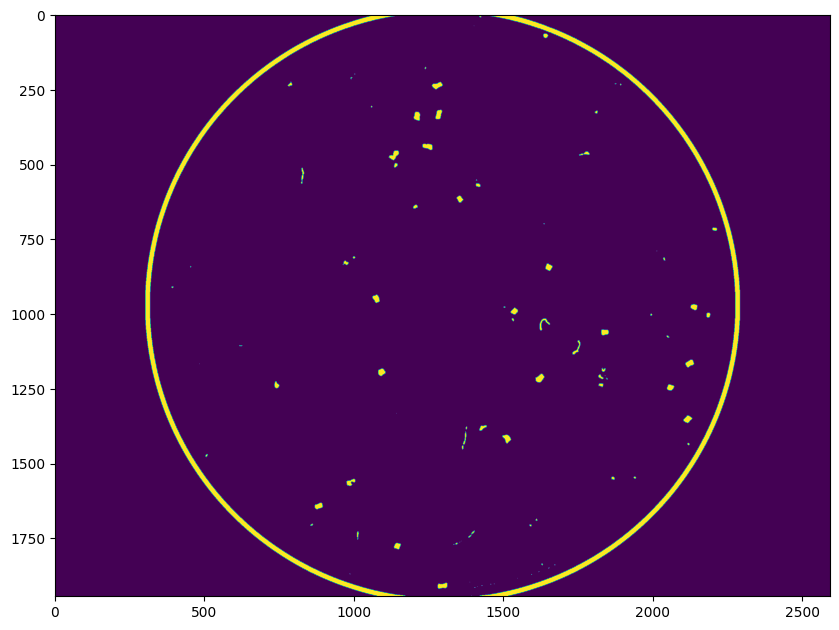

In [66]:
plt.figure(figsize=(10, 10))
plt.imshow(thresh)

In [39]:
openapi.toggle_lights()

<Response [200]>

In [29]:
non_zero_miss_counts = {key: value for key, value in routine.miss_counts.items() if value != 0}
non_zero_miss_counts

{}

In [77]:
idx = 0
well_offset_x = 1
well_offset_y = -1.5
while idx < len(non_zero_miss_counts):
    well_name, miss_count = list(non_zero_miss_counts.items())[idx]
    r = openapi.aspirate(openapi.labware_dct['6'], f"{well_name}", well_location = 'bottom', offset = (well_offset_x,well_offset_y,3), volume = miss_count*10, flow_rate = 5)
    responce_dict = json.loads(r.text)['data']
    if responce_dict['status'] == 'failed':
        if responce_dict['error']['errorType'] == 'InvalidAspirateVolumeError':
            print('Dumping fluid')
            openapi.blow_out(openapi.labware_dct['3'], "B2", well_location='center', flow_rate = 200)
    else:
        idx += 1
    
openapi.blow_out(openapi.labware_dct['3'], "B2", well_location='center', flow_rate = 200)
openapi.move_relative('z', 20)

<Response [201]>

In [97]:
openapi.blow_out_in_place()

<Response [201]>

# Cuboid recognition

In [24]:
calibration_data = utils.load_calibration_config(calibration_profile)

tf_mtx = np.array(calibration_data['tf_mtx'])
calib_origin = np.array(calibration_data['calib_origin'])[:2]
offset = np.array(calibration_data['offset'])


# window = cap.get_window()

def on_mouse_click(event, x, y, flags, param):
    global circle_center
    global circle_radius
    global filtered_contours
    global X_init, Y_init

    if event == cv2.EVENT_MBUTTONDOWN:
        circle_center = (x, y)

    if event == cv2.EVENT_MOUSEWHEEL:
        if flags > 0:
            circle_radius += 10
        else:
            circle_radius -= 10

    # if event == cv2.EVENT_LBUTTONDBLCLK:
    #     for contour in filtered_contours:
    #         r=cv2.pointPolygonTest(contour, (x,y), False)
    #         if r>0:
    #             M = cv2.moments(contour)
    #             if M["m00"] != 0:
    #                 cX = int(M["m10"] / M["m00"])
    #                 cY = int(M["m01"] / M["m00"])
    #                 X_init, Y_init, _ = tf_mtx @ (cX, cY, 1)

    #                 x, y, _ = openapi.get_position(verbose=False)[0].values()
    #                 diff = np.array([x,y]) - np.array(calibration_data['calib_origin'])[:2]
    #                 X = X_init + diff[0] + offset[0]
    #                 Y = Y_init + diff[1] + offset[1]
                    
    #                 print(f"Robot coords: ({x}, {y})")
    #                 print(f"Clicked on: ({X}, {Y})")
    #                 openapi.move_to_coordinates((X, Y, 15), min_z_height=1, verbose=False)
    #                 # openapi.aspirate_in_place(flow_rate = 75, volume = 10)

                    
    #             else:
    #                 print("Contour center could not be found")

    # if event == cv2.EVENT_RBUTTONDOWN:
    #     x, y, _ = openapi.get_position(verbose=False)[0].values()
    #     # openapi.move_to_coordinates((x, y, 100), min_z_height=1)
    #     openapi.move_to_coordinates((calib_origin[0],calib_origin[1],100), min_z_height=1, verbose=False)

        

# cv2.setMouseCallback(cap.window_name, on_mouse_click)
circle_center = (int(1296.0), int(972.0))
circle_radius = 900
# manual_movement = utils.ManualRobotMovement(openapi)
cv2.namedWindow("video", cv2.WINDOW_NORMAL)
cv2.resizeWindow("video", 1348, 1011)
while True:
    ret, frame = over_cam.read()
    # x, y, z = openapi.get_position(verbose=False)[0].values()
    # (text_width, text_height), _ = cv2.getTextSize(f"Robot coords: ({x:.2f}, {y:.2f}, {z:.2f})", cv2.FONT_HERSHEY_SIMPLEX, 1, 2)
    # cv2.rectangle(frame, (10, 0), (10 + text_width, text_height + 70), (0, 0, 0), -1)
    # cv2.putText(frame, f"Robot coords: ({x:.2f}, {y:.2f}, {z:.2f})", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    # cv2.putText(frame, f"Step size: {manual_movement.step} mm", (10, 70), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)


    cv2.circle(frame, circle_center, circle_radius, (255, 0, 0), 2)
    # Create a mask with the same dimensions as the frame
    mask = np.zeros_like(frame, dtype=np.uint8)

    # Draw a filled circle on the mask
    cv2.circle(mask, circle_center, circle_radius, (255, 255, 255), -1)

    # Apply the mask to the frame
    masked_frame = cv2.bitwise_and(frame, mask)

    # Convert the masked frame to grayscale
    gray = cv2.cvtColor(masked_frame, cv2.COLOR_BGR2GRAY)
    # Apply thresholding to the grayscale image
    # _, thresh = cv2.threshold(gray, 50, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    # _, thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV)
    gray = cv2.GaussianBlur(gray, (11, 11), 0)

    thresh = cv2.adaptiveThreshold(gray,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY_INV,41,2) 
    kernel = np.ones((3,3),np.uint8)
    thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=1)
    # Fill the area outside the circle with black pixels
    # Convert the mask to grayscale
    mask_inv = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    thresh = cv2.bitwise_and(thresh, mask_inv)

    # frame[thresh == 255] = [0, 255, 0]

    # Find contours in the masked frame
    contours, hei = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)



    # Filter the contours to exclude the outermost
    filtered_contours = [contour for contour, h in zip(contours, hei[0]) if h[3] == 1]
    # Filter the contours by size
    filtered_contours = [contour for contour in contours if 15 < cv2.contourArea(contour) < 1000]
    # Draw the contours on the frame
    cv2.drawContours(frame, filtered_contours, -1, (0, 255, 0), 2)

    cv2.imshow("video", frame)
    key_pressed = cv2.waitKey(1)

    if key_pressed == ord('q'):
        keyboard.unhook_all()
        break

        
cv2.destroyAllWindows()

In [70]:
openapi.move_to_well(openapi.labware_dct['6'], 'A1', well_location='top', offset=(1,-1,0), verbose=False)

<Response [201]>